In [6]:
from tracr.compiler import compiling
from tracr.compiler import lib
from tracr.rasp import rasp
     
import torch as t
from torch import Tensor, nn , optim
from torch.utils.data import DataLoader
from transformer_lens.utils import to_numpy
import plotly.express as px
from tqdm.notebook import tqdm
from dataclasses import dataclass
import pprint
import plotly.express as px
import einops
from jax import numpy as jnp
import matplotlib.pyplot as plt

from devinterp.slt import estimate_learning_coeff_with_summary
from devinterp.optim import SGLD
from devinterp.utils import plot_trace


import importlib
from copy import deepcopy

def reload_fuctions():
    '''
    Reloads the functions from the utils package. 
    This is useful when you are working on the functions 
    and want to see the changes without restarting the kernel.'''
    import utils

    importlib.reload(utils.data)
    importlib.reload(utils.model)
    importlib.reload(utils.plotting)

    globals().update({name: getattr(utils.data, name) for name in dir(utils.data)})
    globals().update({name: getattr(utils.model, name) for name in dir(utils.model)})
    globals().update({name: getattr(utils.plotting, name) for name in dir(utils.plotting)})

    

from utils.data import *
from utils.model import *
from utils.plotting import *

device = t.device('cuda' if t.cuda.is_available() else 'cpu')

# Tracr sorting model
It translates the inputs into unique keys and sort them using unique sort. which is implemented like this:
```python

```

In [7]:
input_size = 10
vocab = {*range(input_size)}
program = lib.make_sort(rasp.tokens, rasp.tokens, max_seq_len=input_size, min_key=0)

assembled_model = compiling.compile_rasp_to_model(
      program=program,
      vocab=vocab,
      max_seq_len=input_size,
      compiler_bos="bos",
      mlp_exactness=100)

INPUT_ENCODER = assembled_model.input_encoder
OUTPUT_ENCODER = assembled_model.output_encoder

CUDA backend failed to initialize: Found CUDA version 12010, but JAX was built against version 12030, which is newer. The copy of CUDA that is installed must be at least as new as the version against which JAX was built. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [118]:
print(x)
print(y.decoded)

['bos', 0, 7, 0, 4, 2, 6, 8, 5, 0, 4]
['bos', 0, 0, 0, 2, 4, 0, 5, 6, 7, 8]


In [147]:
x = ['bos'] + np.random.randint(10, size=10).tolist()
print("test")
y = assembled_model.apply(x)
out = y.transformer_output

## Tracr model Config
After compling we see that the model has 2 layers, which is less that the maximum sequence length, meaning that the model is able to sort sequences longer than it's model length

In [118]:
pprint.pprint(assembled_model.model_config)

TransformerConfig(num_heads=1,
                  num_layers=3,
                  key_size=12,
                  mlp_hidden_size=100,
                  dropout_rate=0.0,
                  activation_function=<jax._src.custom_derivatives.custom_jvp object at 0x7fe600519990>,
                  layer_norm=False,
                  causal=False)


In [153]:
reload_fuctions()
TRAIN = True

cfg = cfg_from_tracr(assembled_model)
model = HookedTransformer(cfg)
model_mid_decay = HookedTransformer(cfg)
model_high_decay = HookedTransformer(cfg)
tr_model = HookedTransformer(cfg)
tr_model = load_tracr_weights(tr_model, assembled_model, cfg)
criterion = transformers_cross_entropy
decays = [0, 0.01, 0.1]
models =[model, model_mid_decay, model_high_decay]
name_dict = {0: "no",
             0.01: "mid",
             0.1: "high"}
lr=.001
m_losses = []
m_accuracies = []
m_metrics = []

if TRAIN:
    epochs = 30
    batch_size = 4096//2
    for penalty in [l1_pentaly_activation]:
        for lamb,m in zip(decays, models):
            optimizer = t.optim.AdamW(m.parameters(), lr=lr)

            

            
            
            save_path = f'models/sort_{name_dict[lamb]}_l1_activation.pth' 
            print(save_path)

            losses, accuracy, metrics = train_model(m, optimizer, criterion, penalty(lamb), train_loader, epochs, batch_size, input_size, len(vocab), test_benchmarks, save_path)
            m_losses.append(losses)
            m_accuracies.append(accuracy)
            m_metrics.append(metrics)
        

save_paths = [f'models/sort_{name_dict[lamb]}_l1_activation.pth' for lamb in decays]

for m, save_path in zip([model, model_mid_decay, model_high_decay], save_paths):
    print(save_path)
    m.load_state_dict(t.load(save_path), strict=True)

models/sort_no_l1_activation.pth


  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:23<00:00,  1.26it/s]


models/sort_mid_l1_activation.pth


100%|██████████| 30/30 [00:23<00:00,  1.26it/s]


models/sort_high_l1_activation.pth


100%|██████████| 30/30 [00:24<00:00,  1.22it/s]

models/sort_no_l1_activation.pth
models/sort_mid_l1_activation.pth
models/sort_high_l1_activation.pth


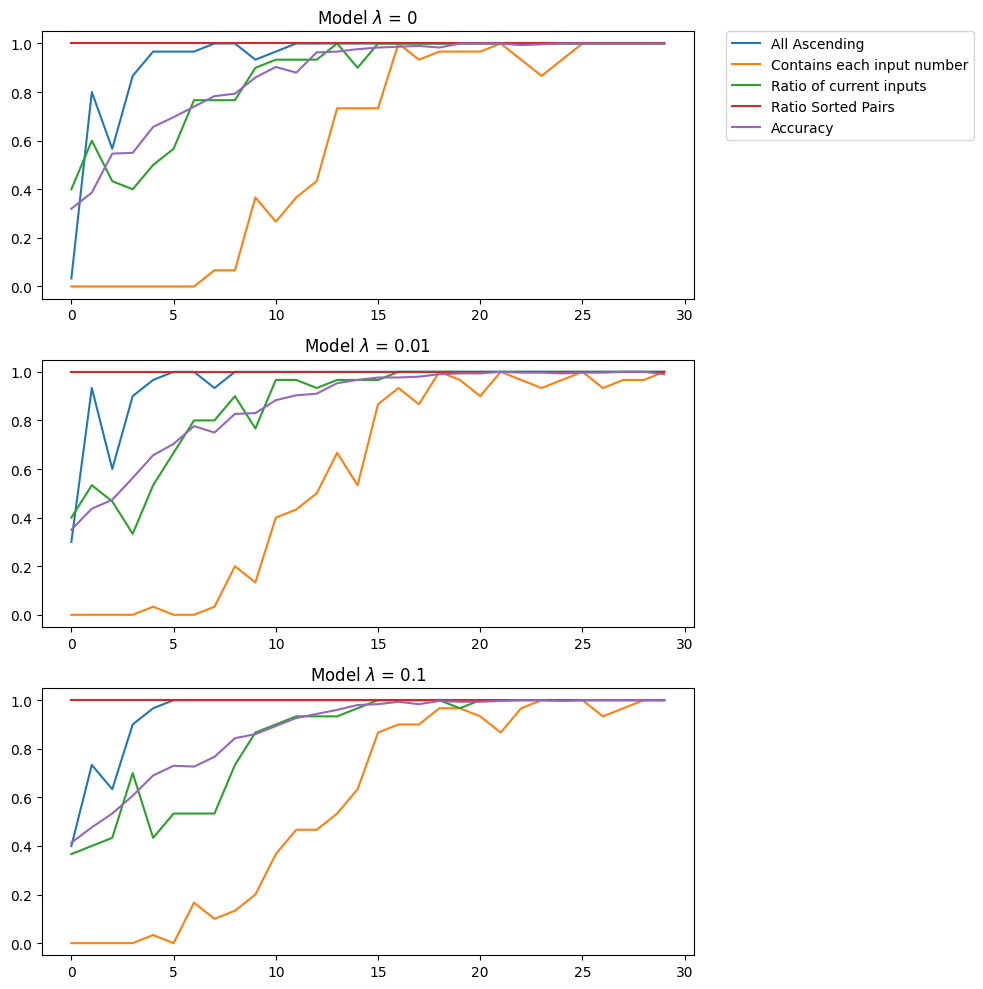

In [154]:
metric_labels = ['All Ascending', 'Contains each input number', 'Ratio of current inputs', 'Ratio Sorted Pairs']
plt.subplots(len(m_metrics),1, figsize=(10,10))

for i in range(len(m_metrics)):

    plt.subplot(len(m_metrics),1,i+1)
    for metric, accuracy, label in zip(m_metrics[i], m_accuracies[i], metric_labels):
        plt.plot(metric, label=label)

    plt.plot(m_accuracies[i], label='Accuracy')
    plt.title(f'Model $\lambda$ = {decays[i]}')

    if i == 0:
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show()


- How sparse can the models get
  - Training tracr with very high sparsity
- activation patching
- LLC try but sign might not be important
- 

In [155]:
import pandas as pd


if True:
    df = pd.DataFrame()
    for idx, loss in enumerate(m_losses):
        df = pd.concat([df, pd.DataFrame(
            {'Epoch': range(len(loss)), 
            'Loss': loss, 
            'Model': f'Model {decays[idx]}'}
            )])

    df.to_csv('sort_mini_activation_sgld.csv')
else:
    df = pd.read_csv('sort_mini.csv')

fig = px.line(df, x='Epoch', y='Loss', color='Model', title='Loss over time', log_y=True)
fig.show()


In [145]:
# means = learning_coeff_stats["llc/means"]
# print(mean(means))
learning_coeff_stats['llc/moving_avg'].mean()

-138.8241

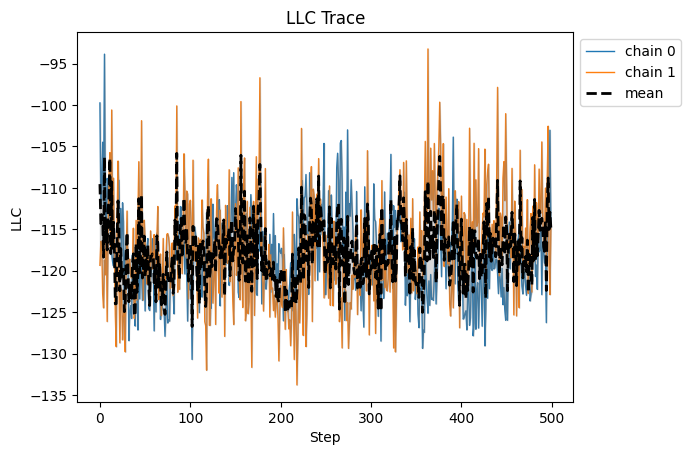

<Figure size 1200x900 with 0 Axes>

In [126]:
plot_trace(
    trace,
    "LLC",
    x_axis="Step",
    title="LLC Trace",
    plot_mean=False,
    plot_std=False,
    fig_size=(12, 9),
    true_lc=None,
)

In [22]:
TRAIN_COMPRESSED = False
reload_fuctions()
compressed_model = deepcopy(model)
compressed_model.compression = CompressionHook(model.cfg.d_model, 1.3)
pre_training_weight = compressed_model.compression.fc_compress.weight.clone()
losses = []
metrics = []
accuracies = []

if TRAIN_COMPRESSED:
    epochs = 300
    batch_size = 4096
    optimizer = t.optim.AdamW(compressed_model.compression.fc_compress.parameters(), lr=1e-3)
    save_path = f'models/sort_mini_compessed.pth' 

    loss, accuracy, bench = train_model(compressed_model, optimizer, criterion, no_pentaly(1), train_loader, epochs, batch_size, input_size, len(vocab), test_benchmarks, save_path)
    losses.extend(loss)
    metrics.extend(bench)
    accuracies.extend(accuracy)


post_training_weight = compressed_model.compression.fc_compress.weight.clone()

In [256]:
px.line(losses, title='Loss over time', log_y=True) 

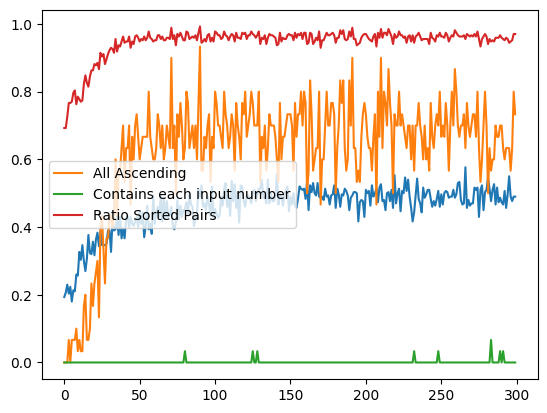

In [263]:
plt.plot(accuracy)
for metric, label in zip(metrics, metric_labels):
    plt.plot(metric, label=label)
plt.legend()
plt.show()

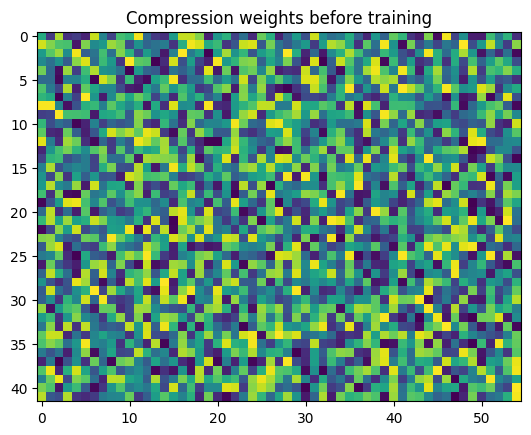

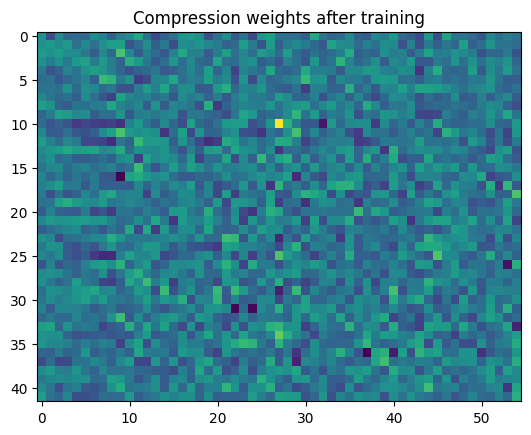

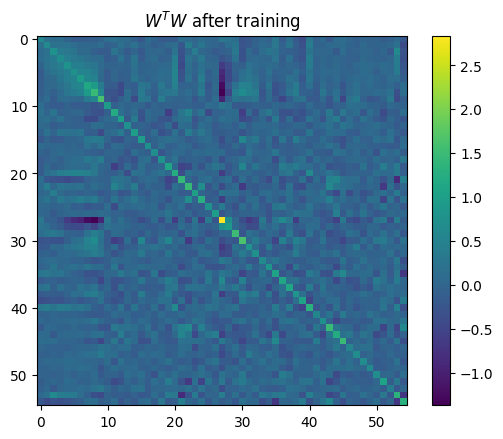

In [265]:
diff_weights = pre_training_weight - post_training_weight
plt.imshow(to_numpy(pre_training_weight))
plt.title("Compression weights before training")
plt.show()
plt.imshow(to_numpy(post_training_weight))
plt.title("Compression weights after training")
plt.show()
plt.imshow(to_numpy(post_training_weight.T) @ to_numpy(post_training_weight))
plt.title("$W^T W$ after training")
plt.colorbar()
plt.show()

I might have lost the data for the original training loss curve

In [127]:
reload_fuctions()

models = [model, model_mid_decay, model_high_decay, assembled_model, tr_model]
model_names = ['Model:\t\t', 'Model 0.01 decay:', 'Model 0.1 decay:','Tracr model:\t', "Tracr model copied"]
input_size = 10
x,y = generate_data(1, len(vocab), input_size)
print('Data in:\t\t', x.squeeze().tolist())
print('Data out:\t\t', y.squeeze().tolist())

for i, mod in enumerate(models):
    if model_names[i] == 'Tracr model copied':
        pred = prompt(mod, x, INPUT_ENCODER, OUTPUT_ENCODER)
    else:
        pred = prompt(mod, x)
    print(f'{model_names[i]}\t', pred)

Data in:		 [3, 7, 8, 7, 7, 3, 2, 5, 5, 8]
Data out:		 [2, 3, 3, 5, 5, 7, 7, 7, 8, 8]
Model:			 [2, 3, 3, 5, 5, 7, 7, 7, 8, 8]
Model 0.01 decay:	 [2, 3, 3, 5, 5, 7, 7, 7, 8, 8]
Model 0.1 decay:	 [2, 3, 3, 5, 5, 7, 7, 7, 8, 8]
Tracr model:		 [2, 3, 7, 5, 7, 7, 7, 8, 8, 7]
Tracr model copied	 [0, 0, 1, 2, 3, 4, 5, 6, 7, 8]


In [129]:
reload_fuctions()
assembled_logits, assembled_cache = run_with_activations(assembled_model, x)
trained_logits, trained_cache = run_with_activations(model, x)
trained_mid_decay_logits, trained_mid_decay_cache = run_with_activations(model_mid_decay, x)
trained_high_decay_logits, trained_high_decay_cache = run_with_activations(model_high_decay, x)
tracr_logits, tracr_cache = run_with_activations(tr_model, x, INPUT_ENCODER)

## Tracr Transformer output reference:
| Activation      | Dimension                          |
|-----------------|------------------------------------|
| layer_outputs   | [Batch, Sequence_Size, d_embedding]|
| residuals       | [Batch, Sequence_Size, d_embedding]|
| attn_logits     | [Batch, n_heads, Sequence_Size, Sequence_Size]|
| output          | [Batch, Sequence_Size, d_embedding]|
| input_embeddings| [Batch, Sequence_size, d_embedding]|

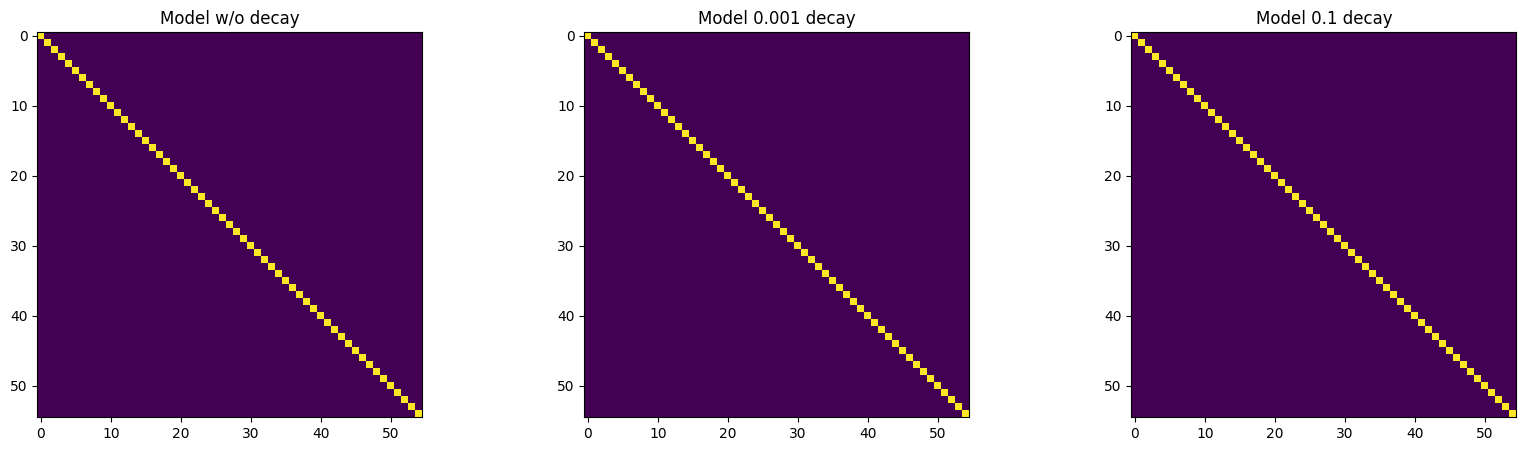

In [76]:
reload_fuctions()
compression_hooks = [m.compression.weight for m in [model, model_mid_decay, model_high_decay]]
compression_hook_names = ['Model w/o decay', 'Model 0.001 decay', 'Model 0.1 decay']

fig, axs = plt.subplots(1, 3, figsize=(20, 5))
for i, hook in enumerate(compression_hooks):
    axs[i].imshow(to_numpy(hook))
    axs[i].set_title(compression_hook_names[i])

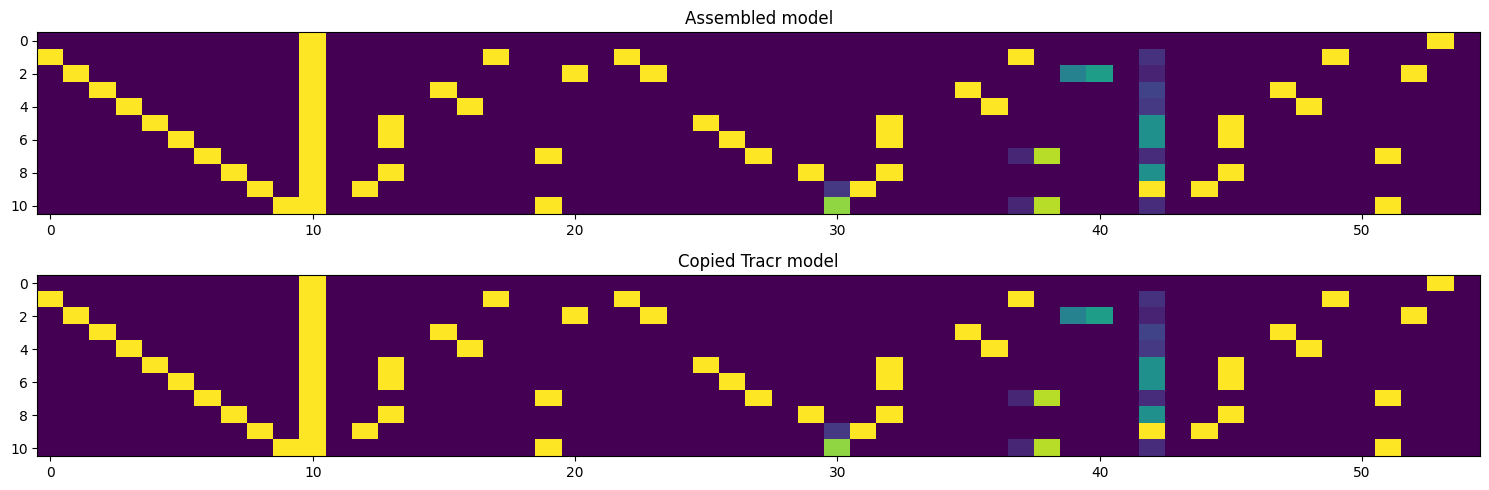

In [130]:
copied_out = to_numpy(tracr_cache['blocks.2.hook_resid_post']).squeeze()
assembled_out = assembled_cache.transformer_output.squeeze()

fig, ax = plt.subplots(2, 1, figsize=(15, 5))
ax[0].imshow(assembled_out, aspect='auto')
ax[0].set_title('Assembled model')
ax[1].imshow(copied_out, aspect='auto')
ax[1].set_title('Copied Tracr model')
plt.tight_layout()
plt.show()

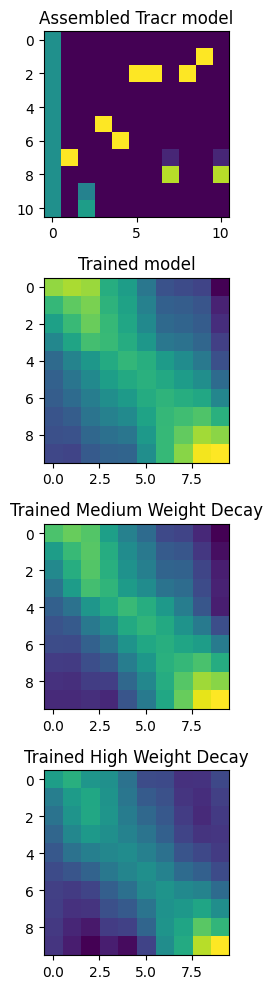

In [131]:
reload_fuctions()
logits = [
    np.array(assembled_logits[-1]),
    to_numpy(trained_logits),
    to_numpy(trained_mid_decay_logits),
    to_numpy(trained_high_decay_logits),
]

plot_activations(["Assembled Tracr model", "Trained model", "Trained Medium Weight Decay", "Trained High Weight Decay"], *logits)

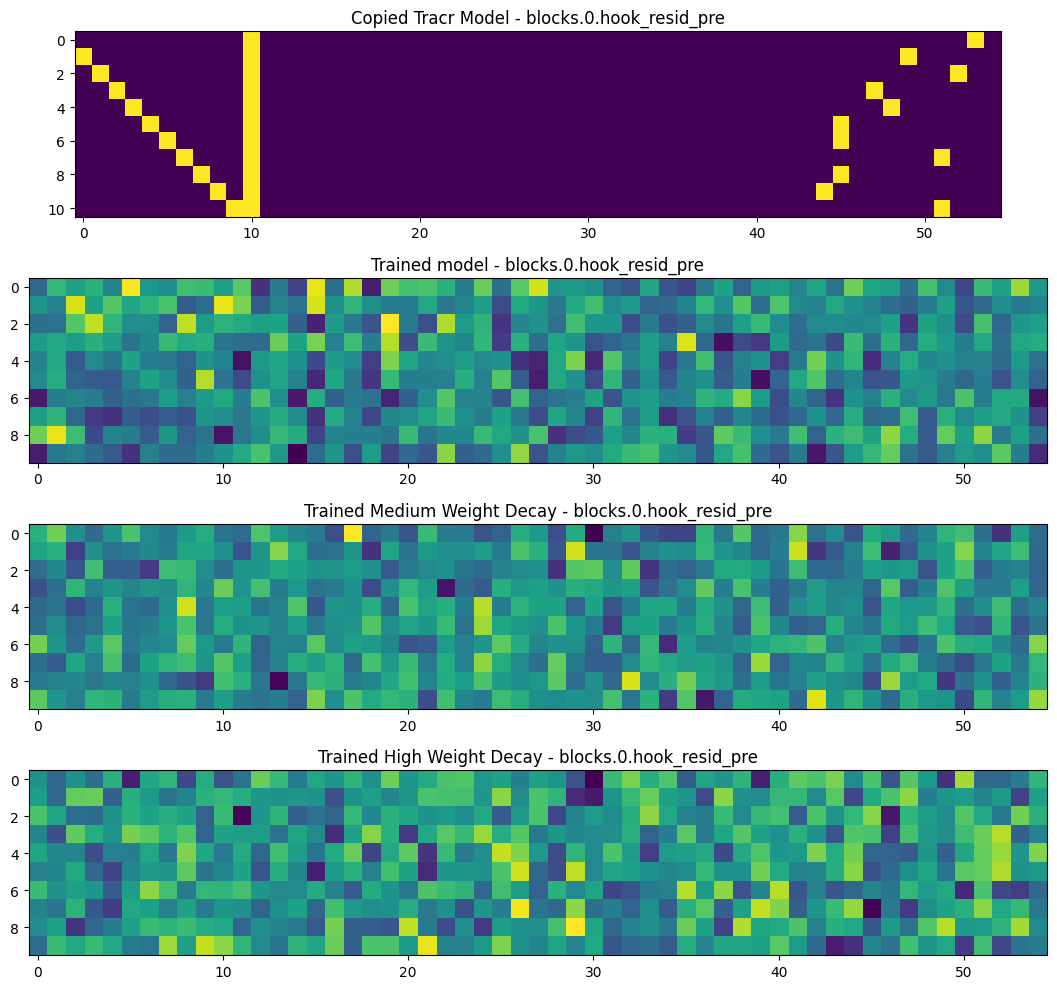

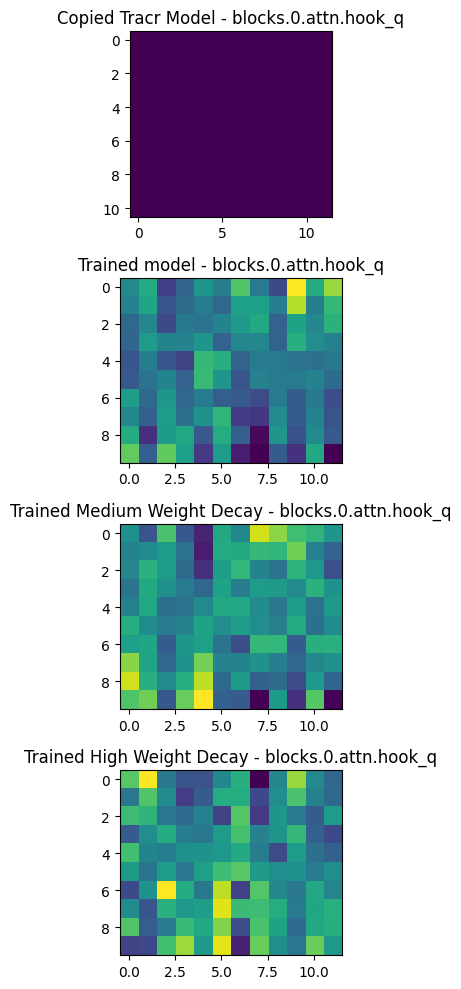

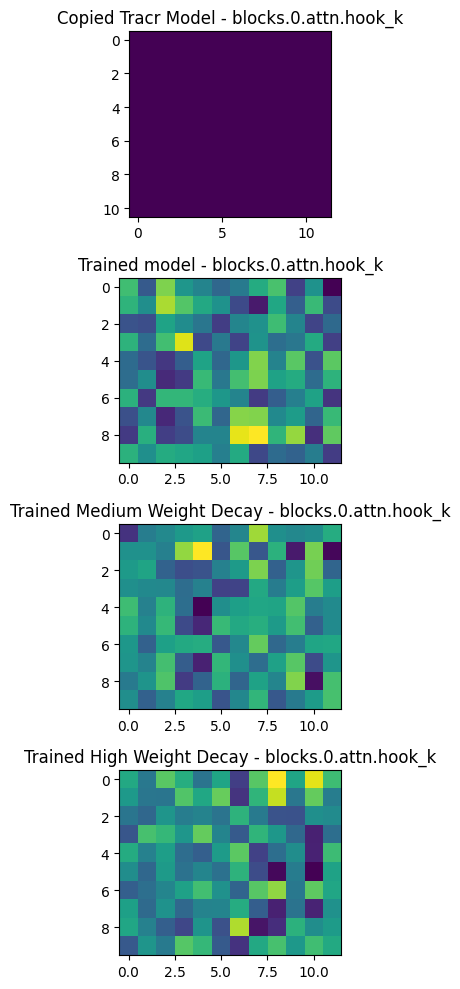

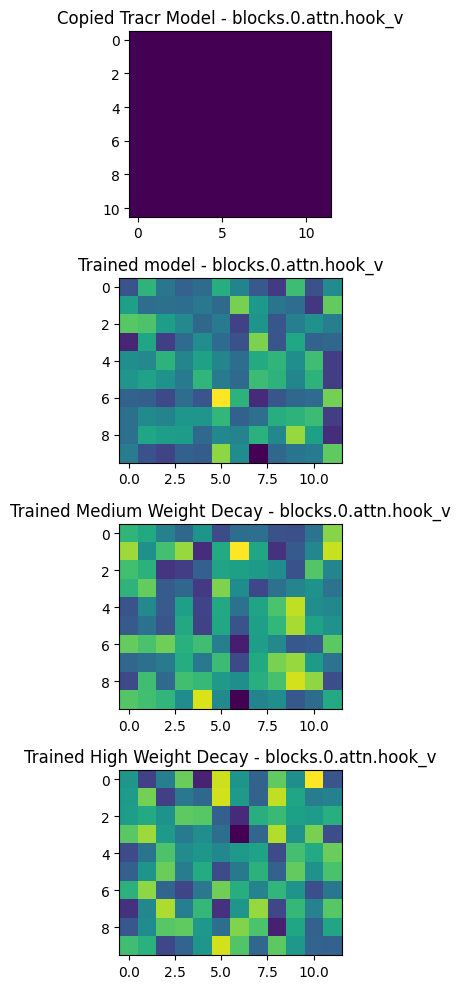

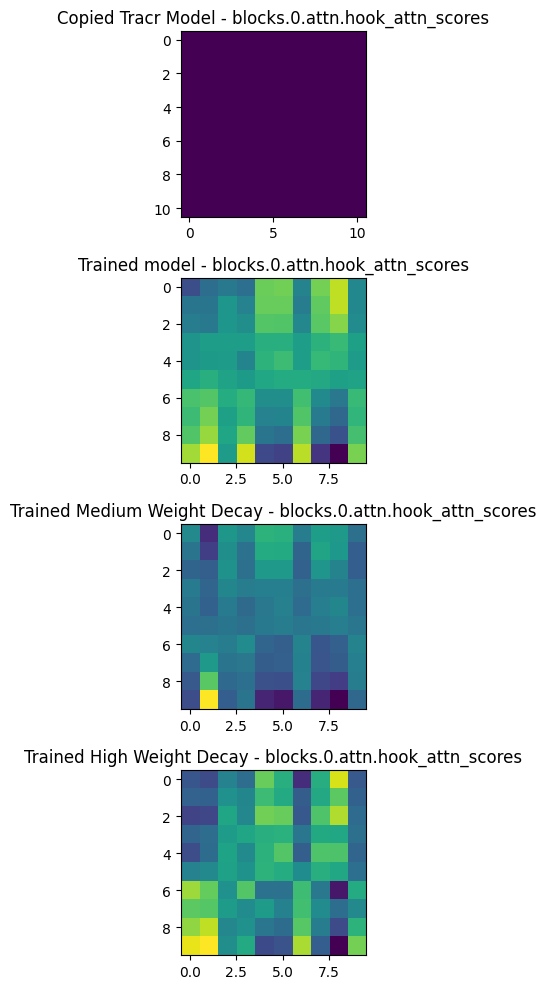

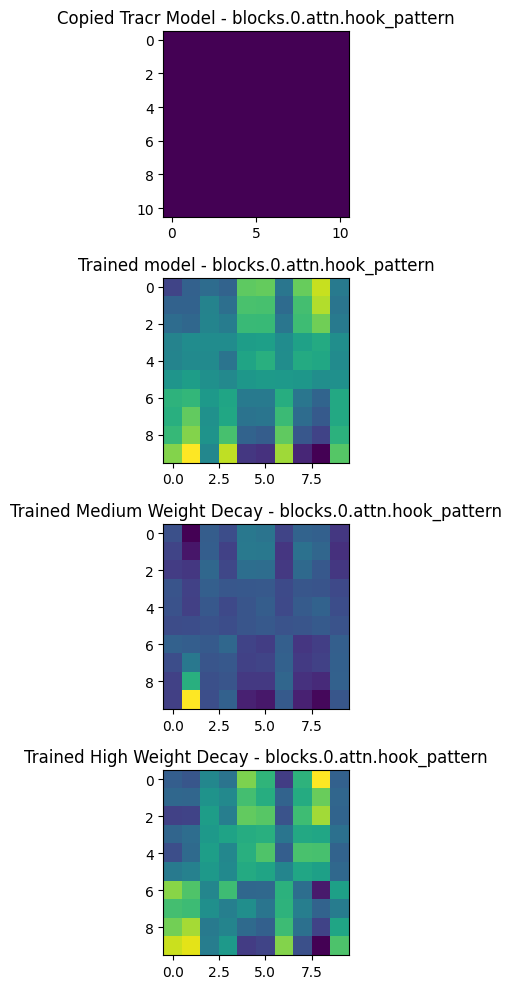

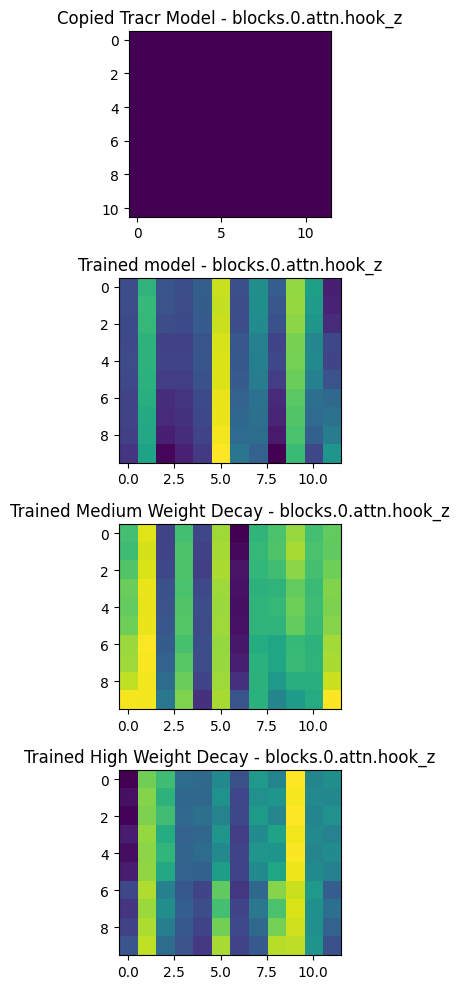

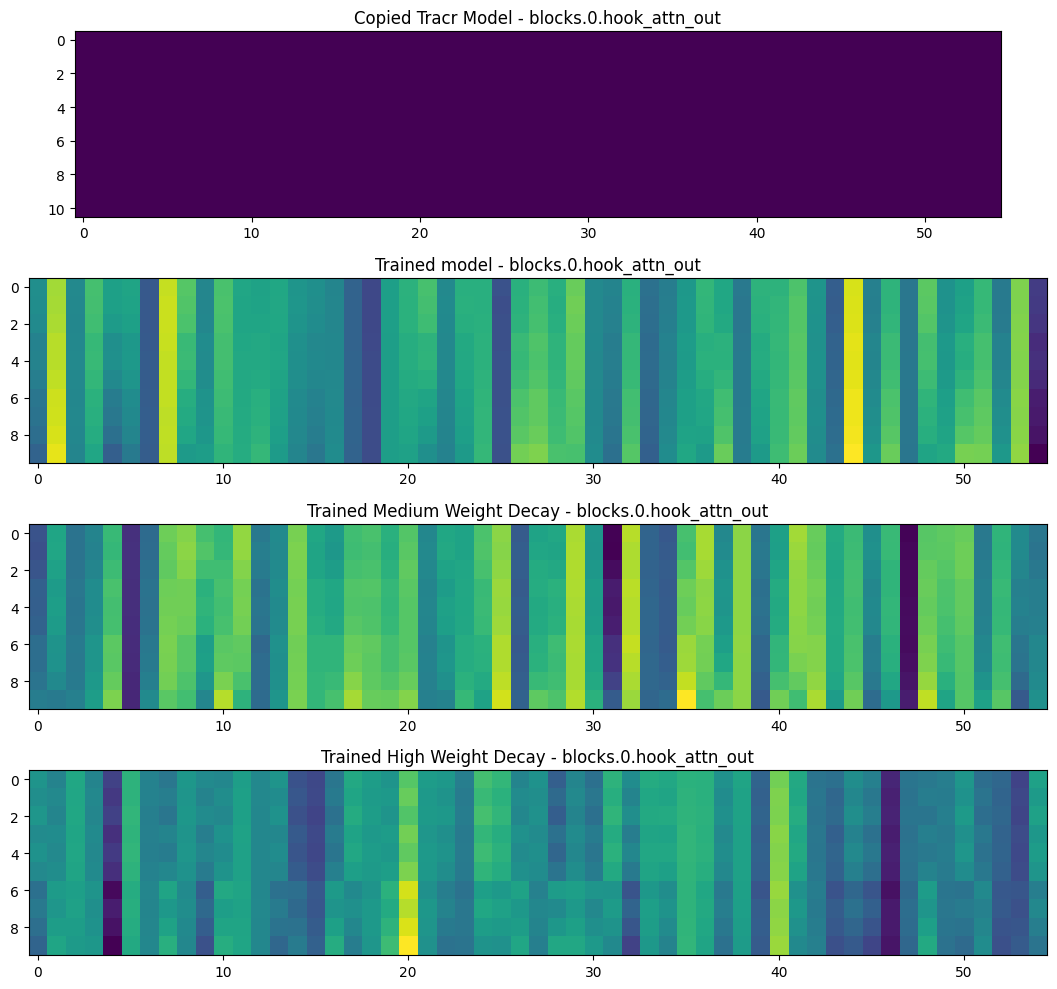

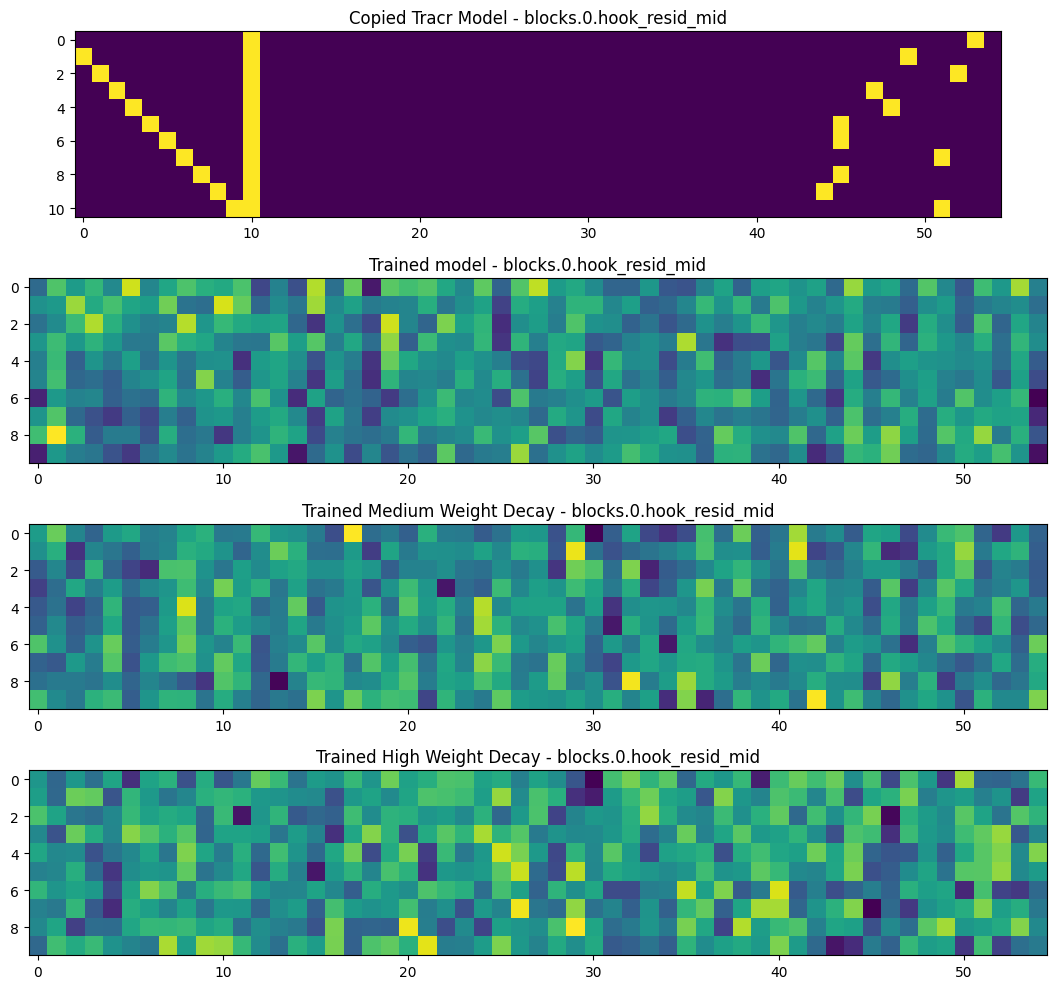

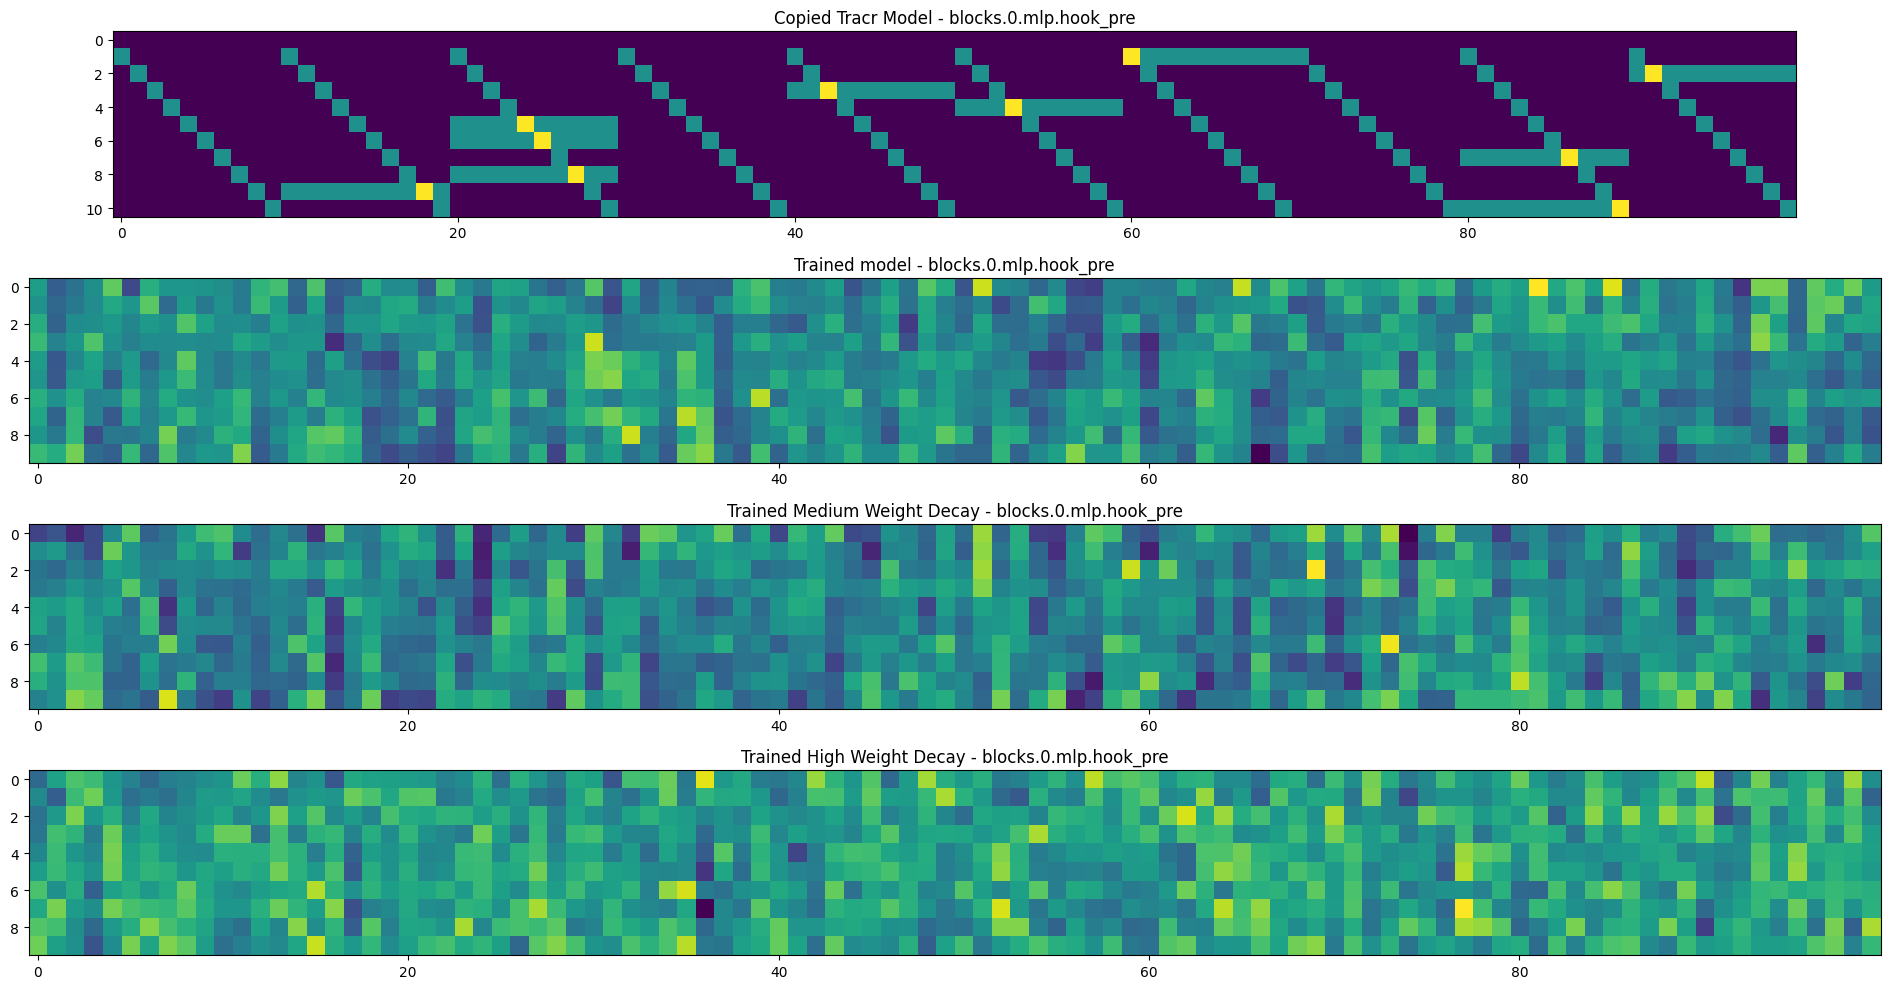

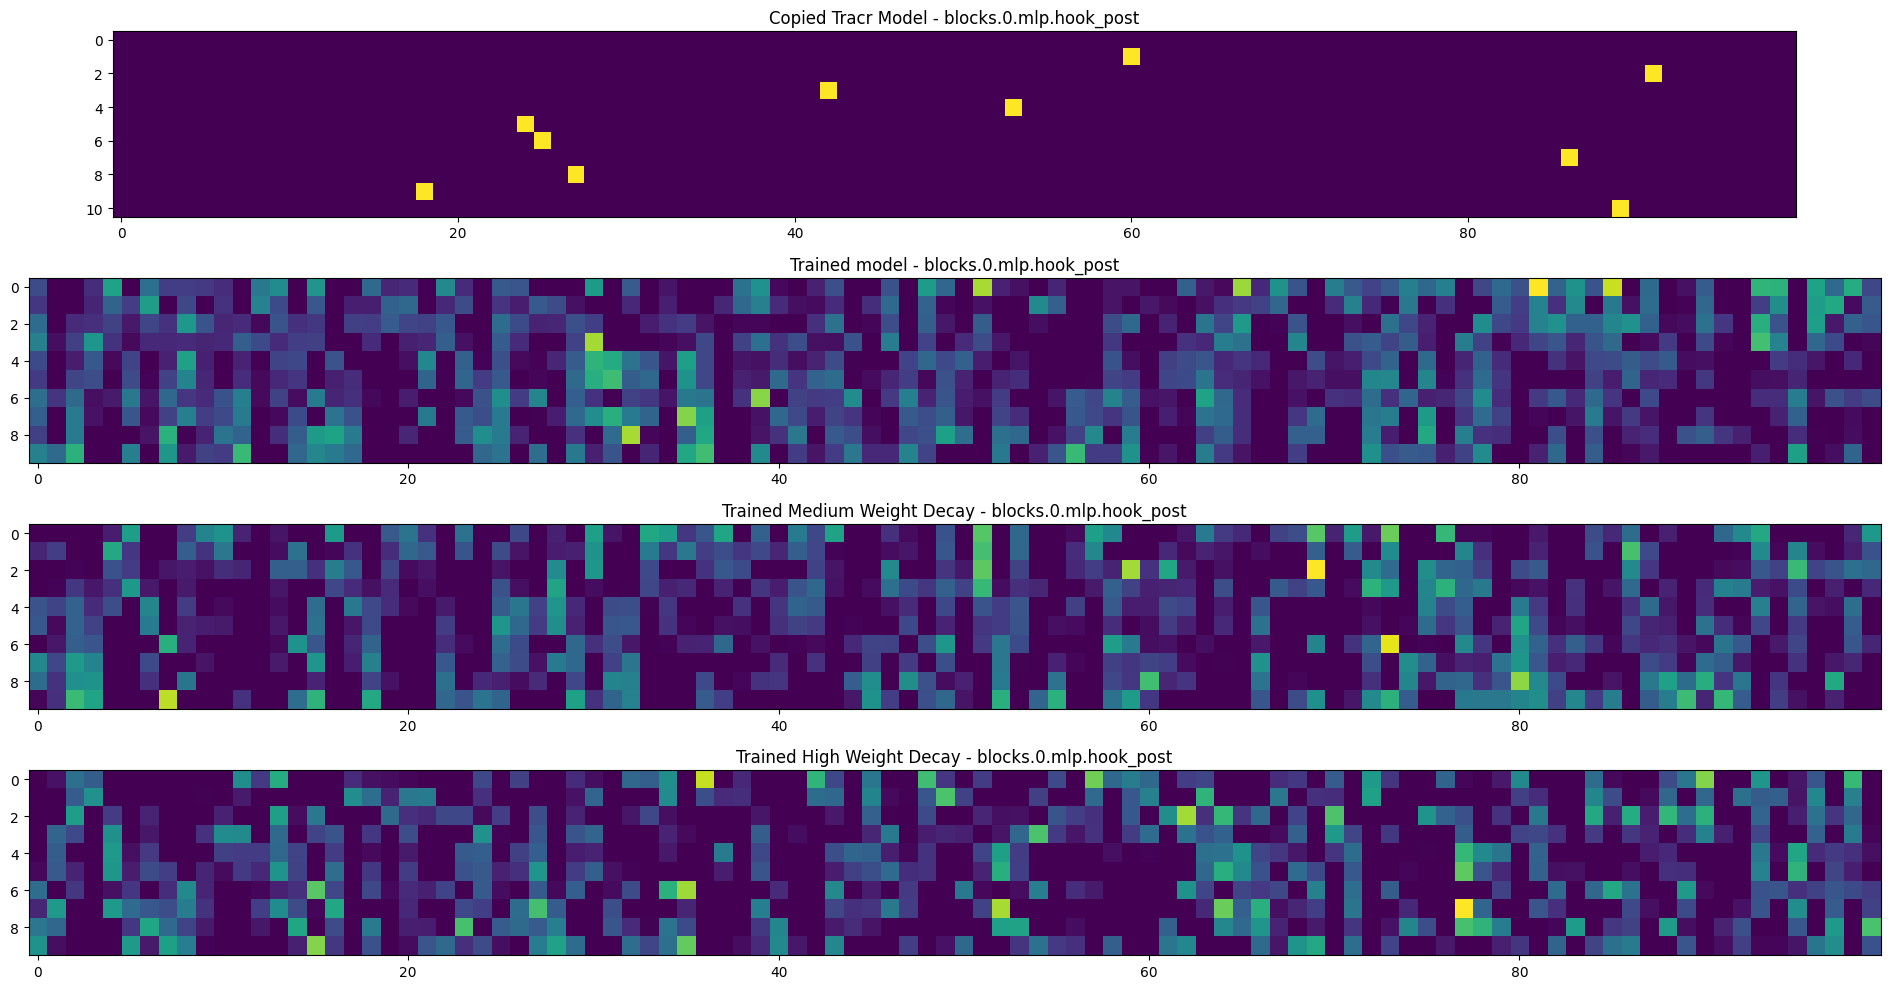

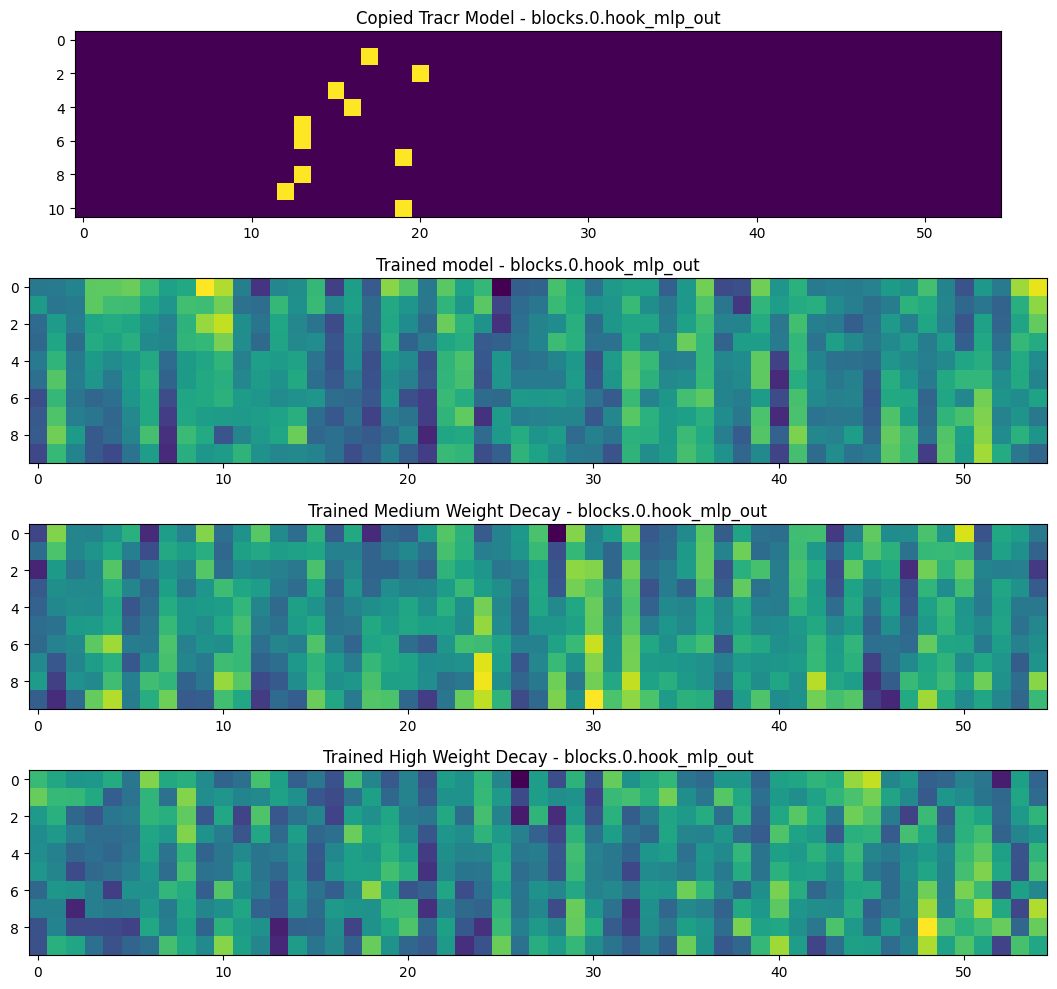

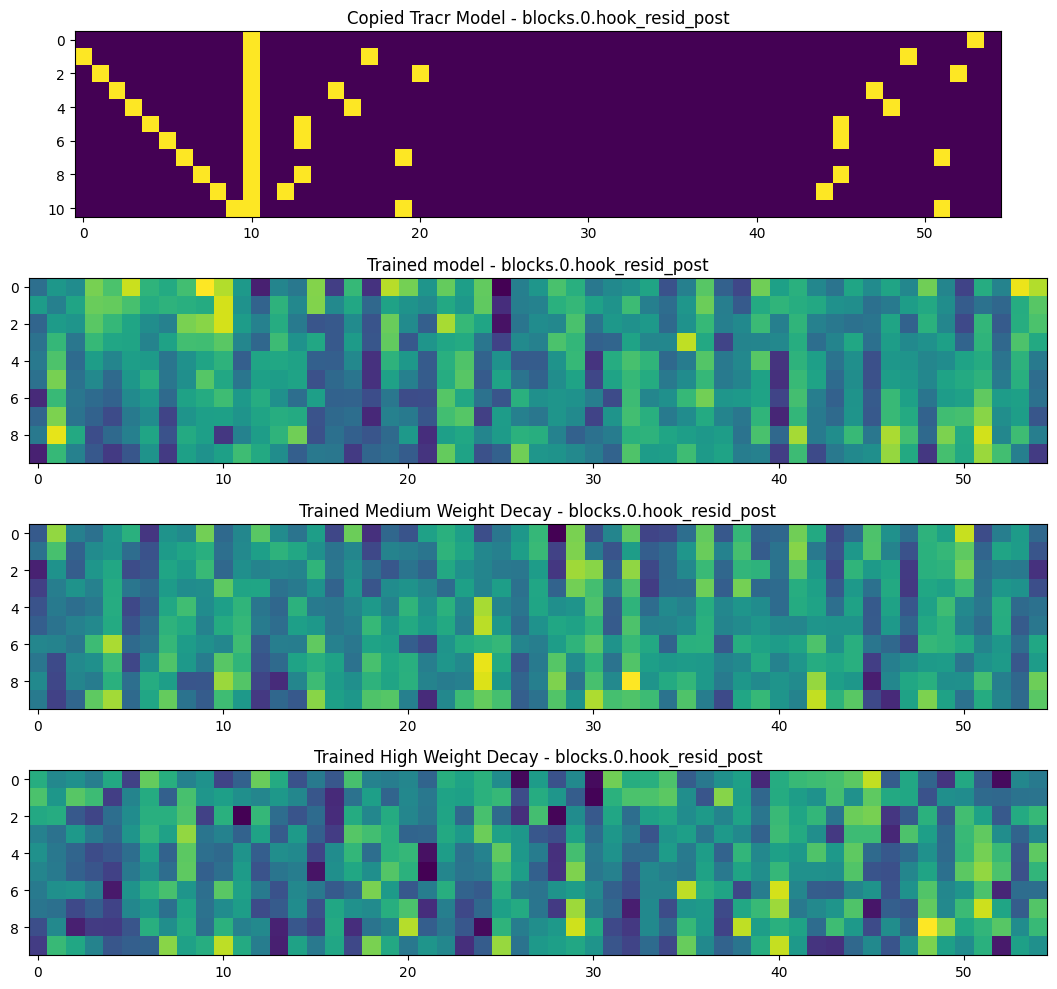

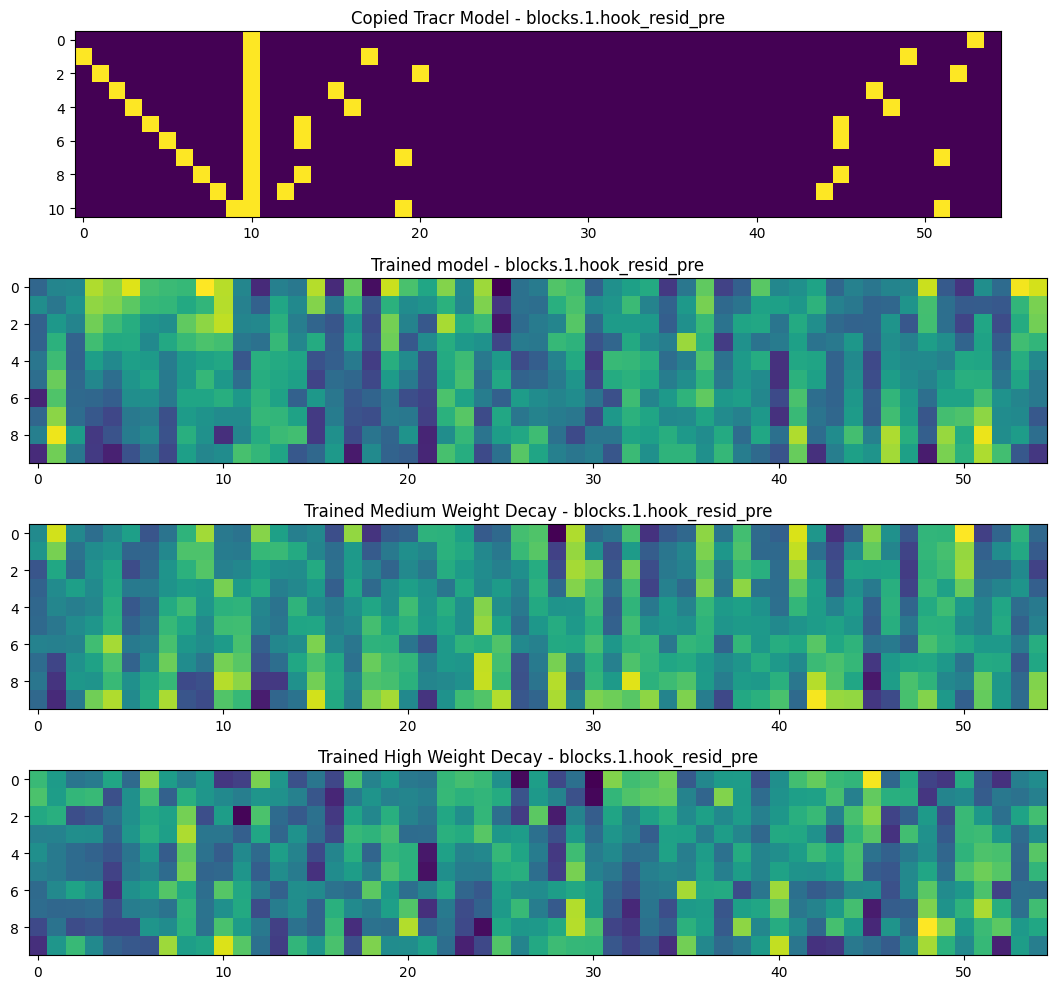

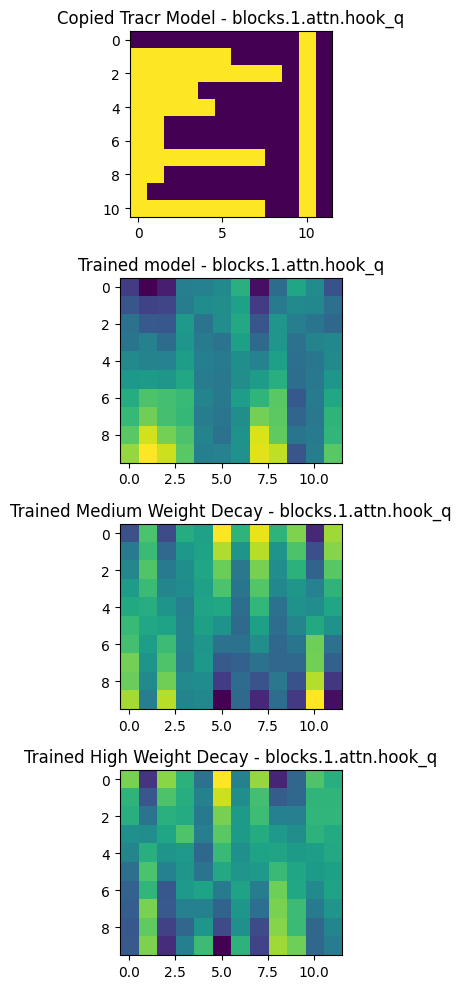

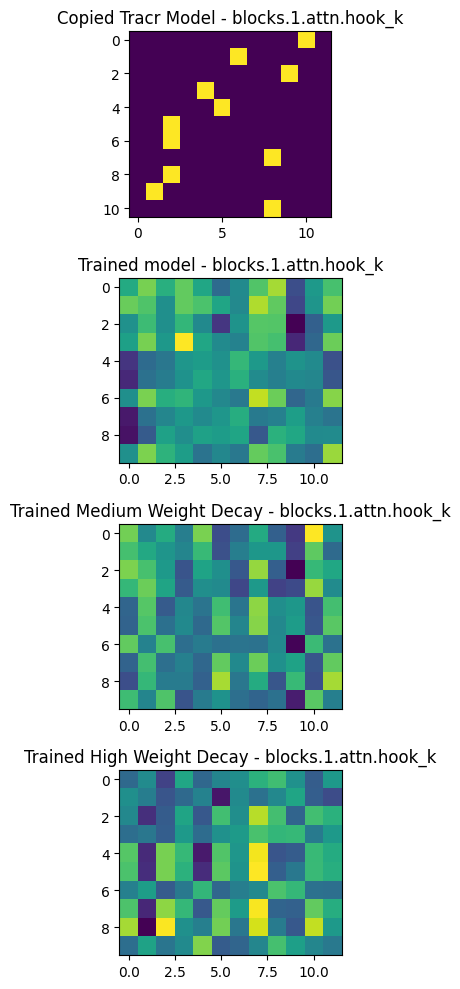

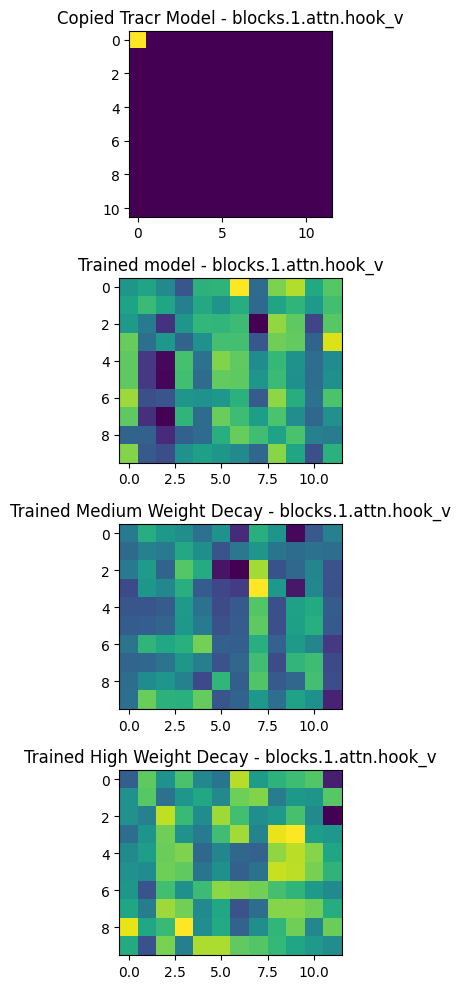

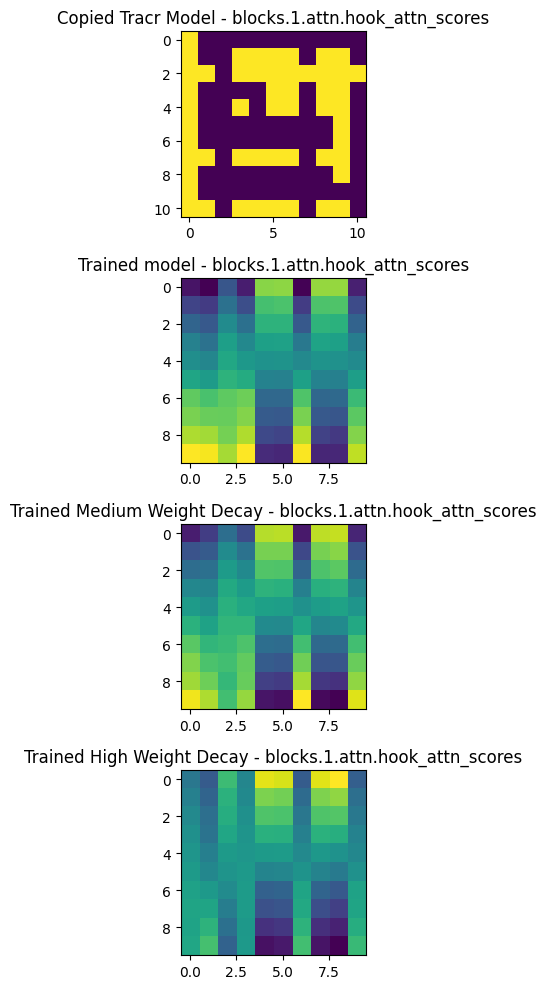

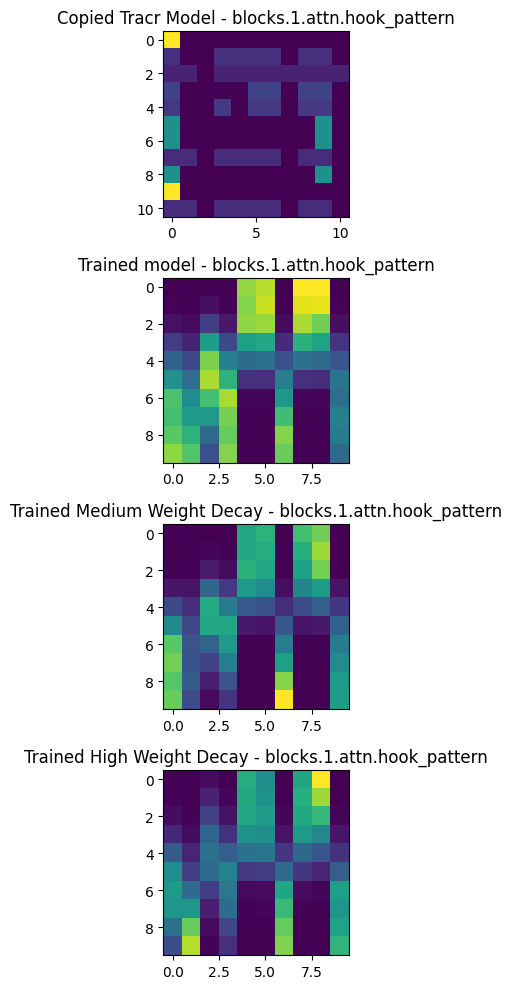

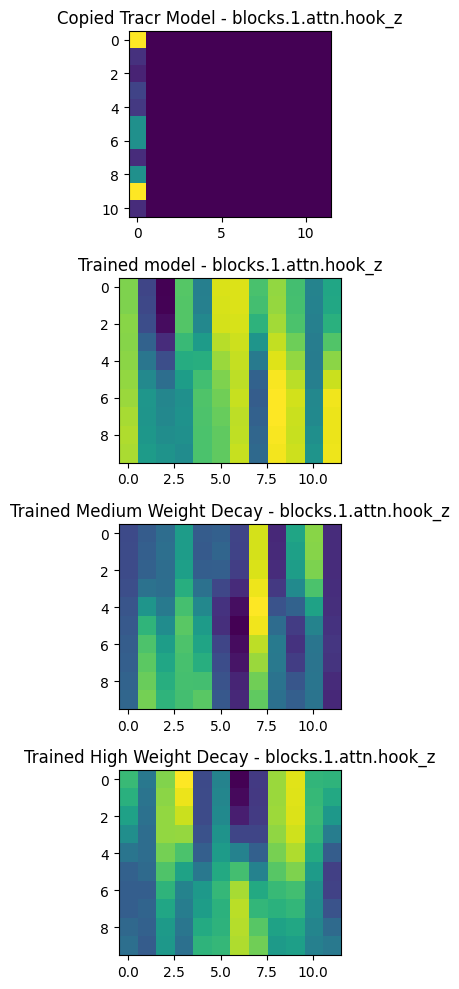

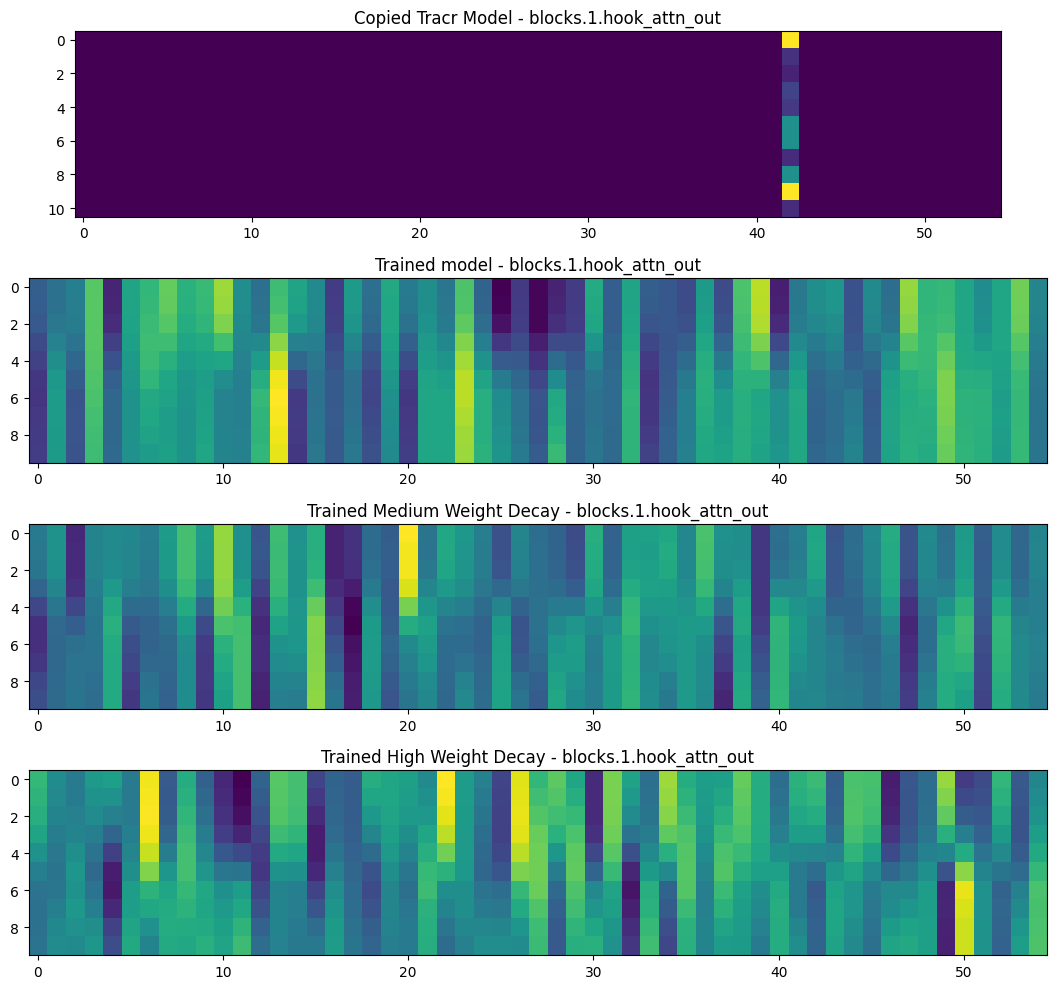

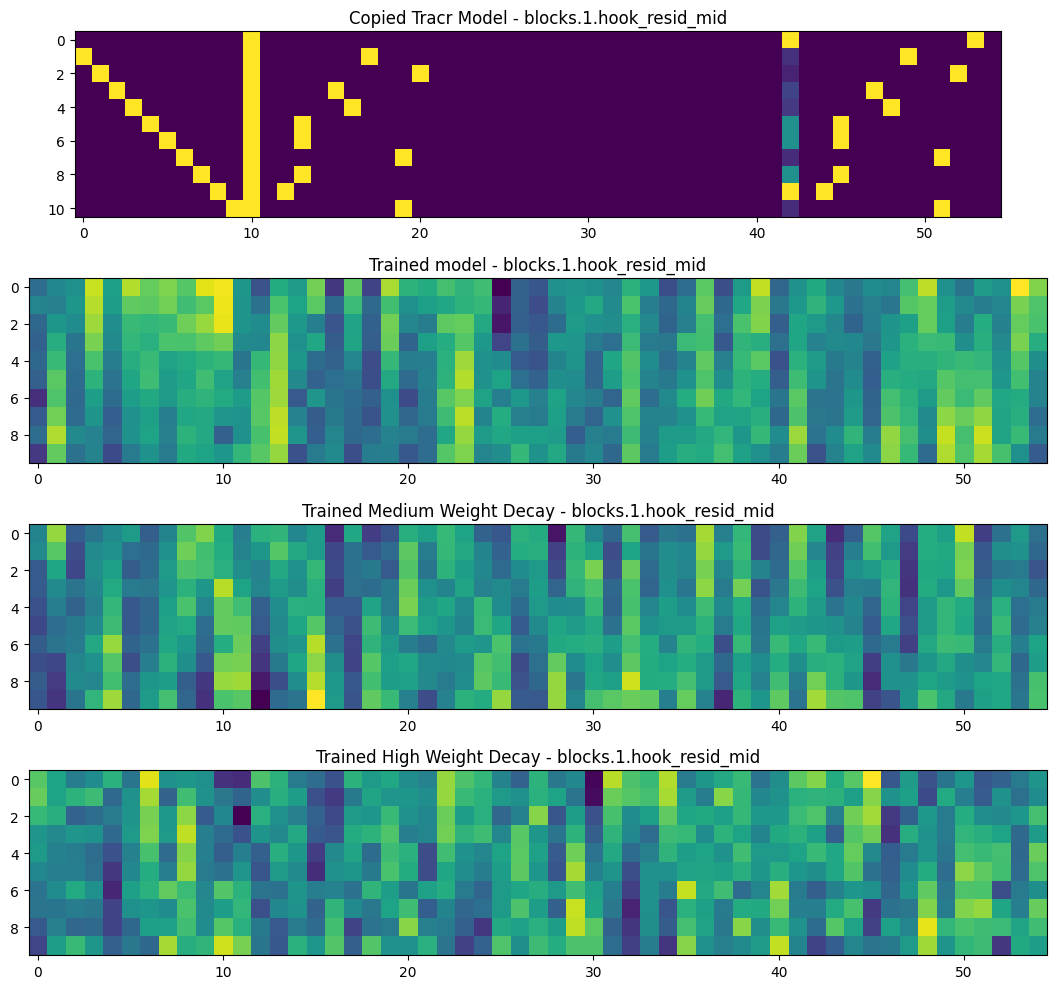

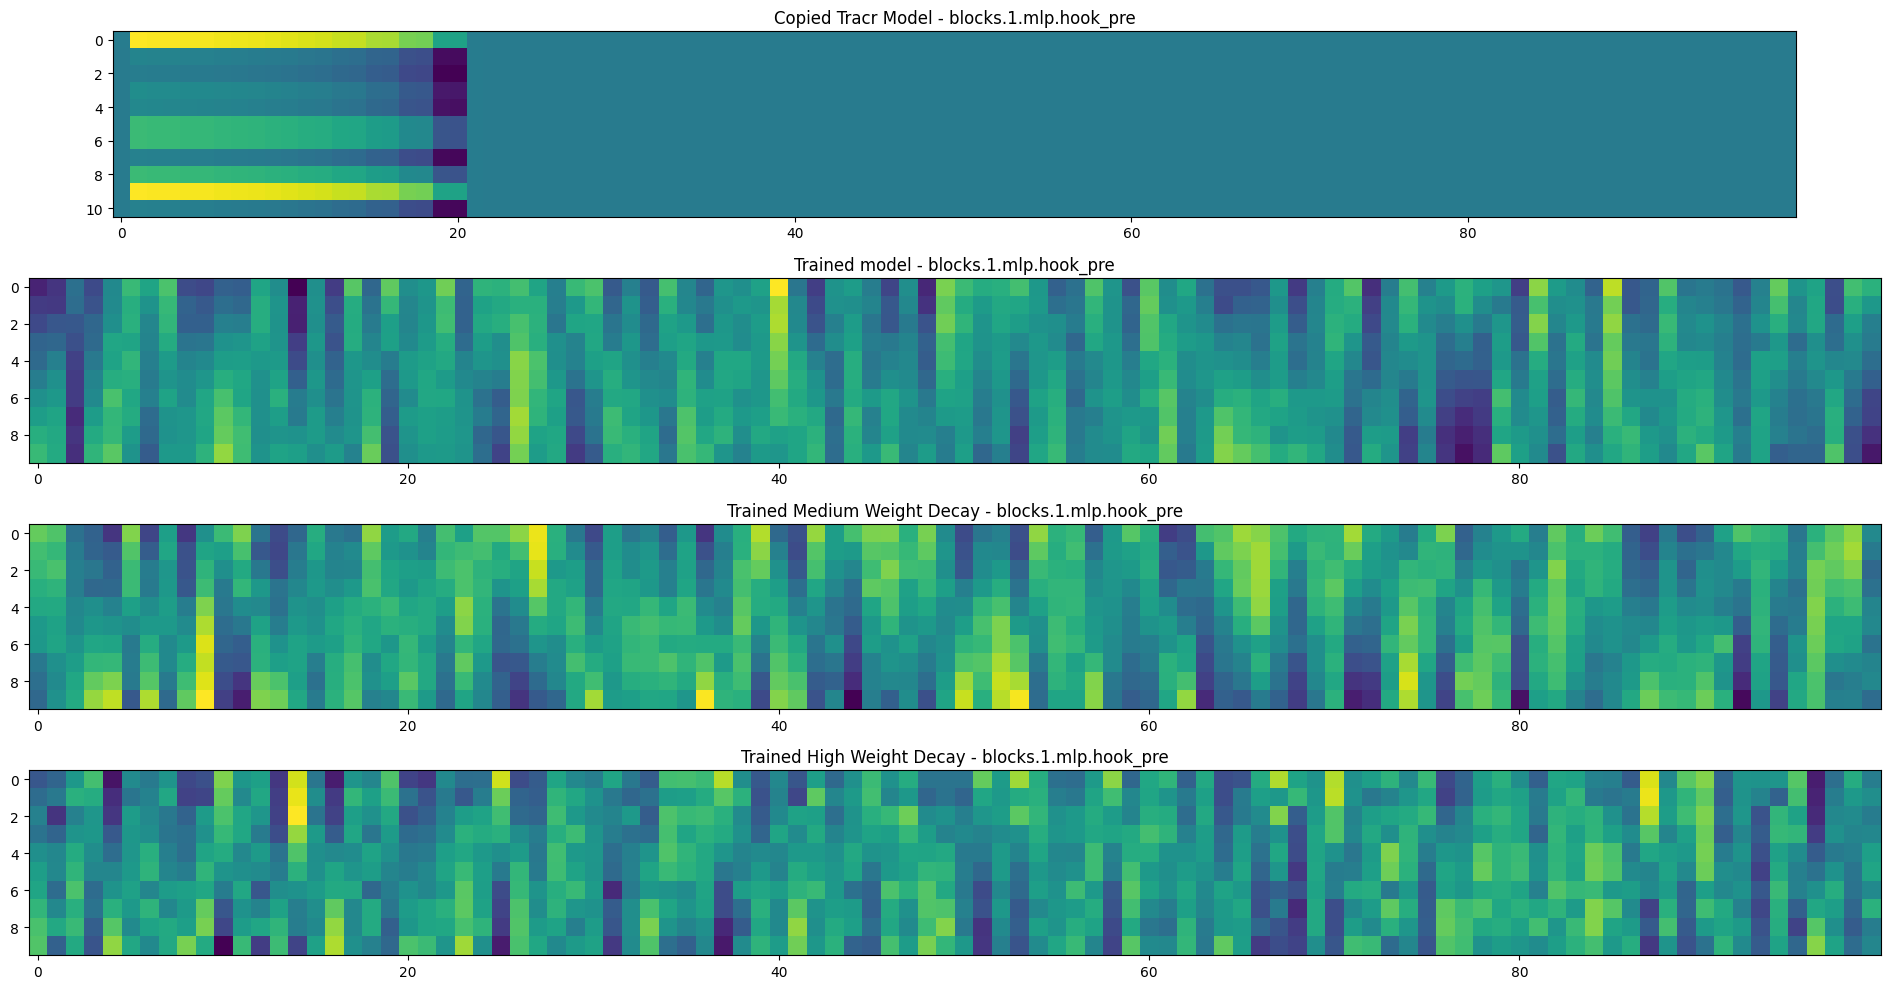

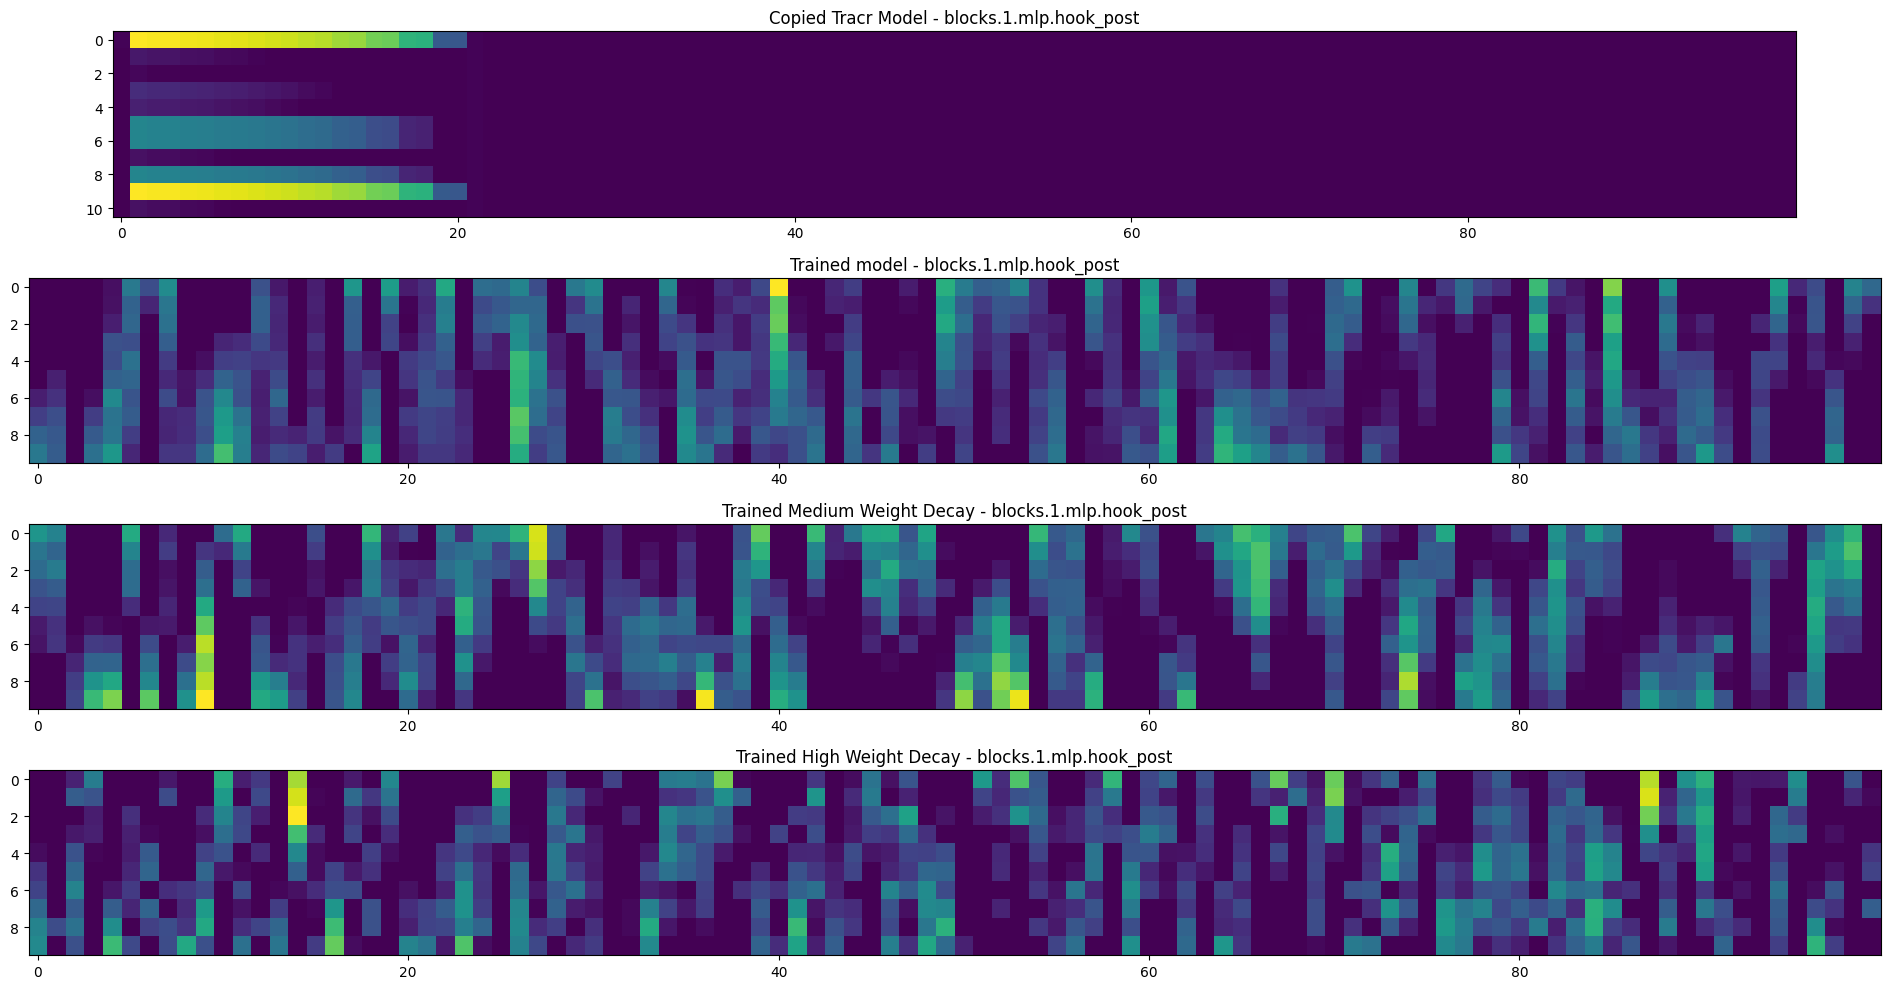

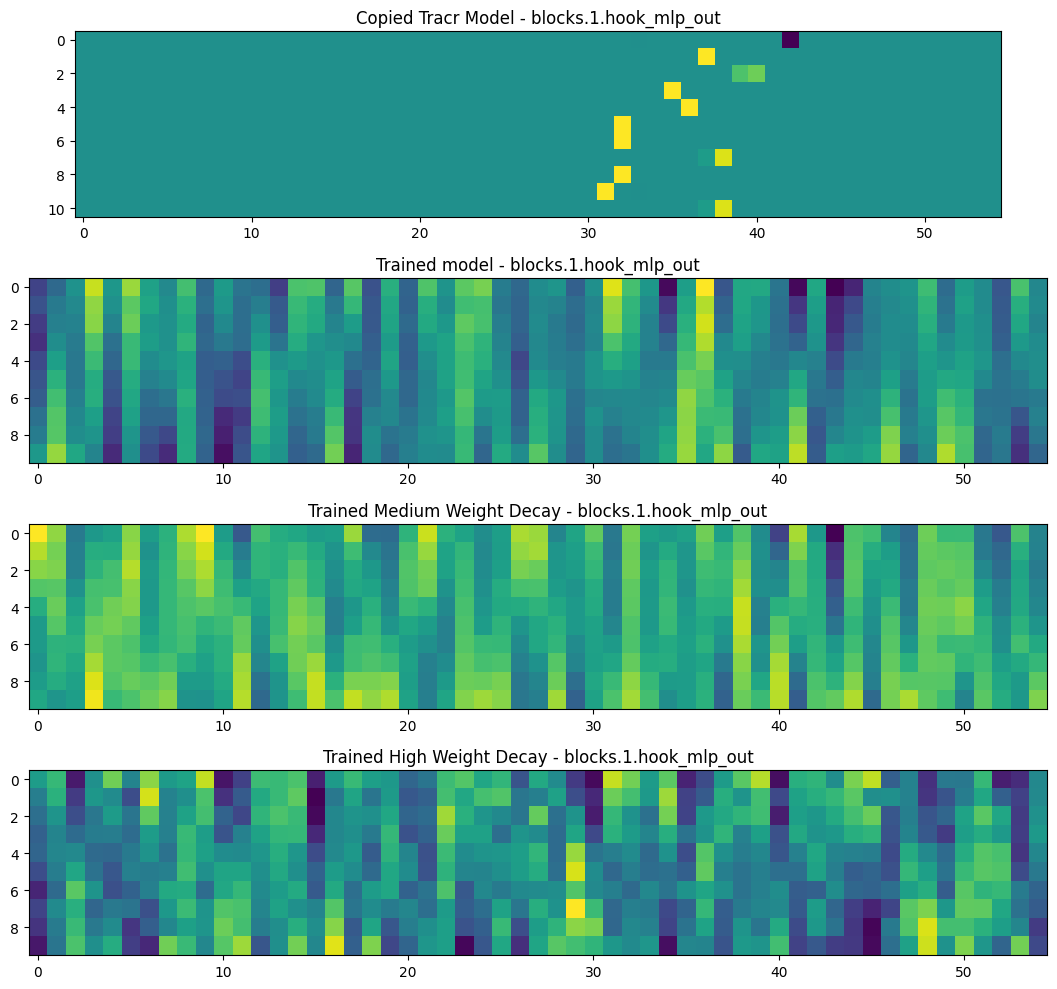

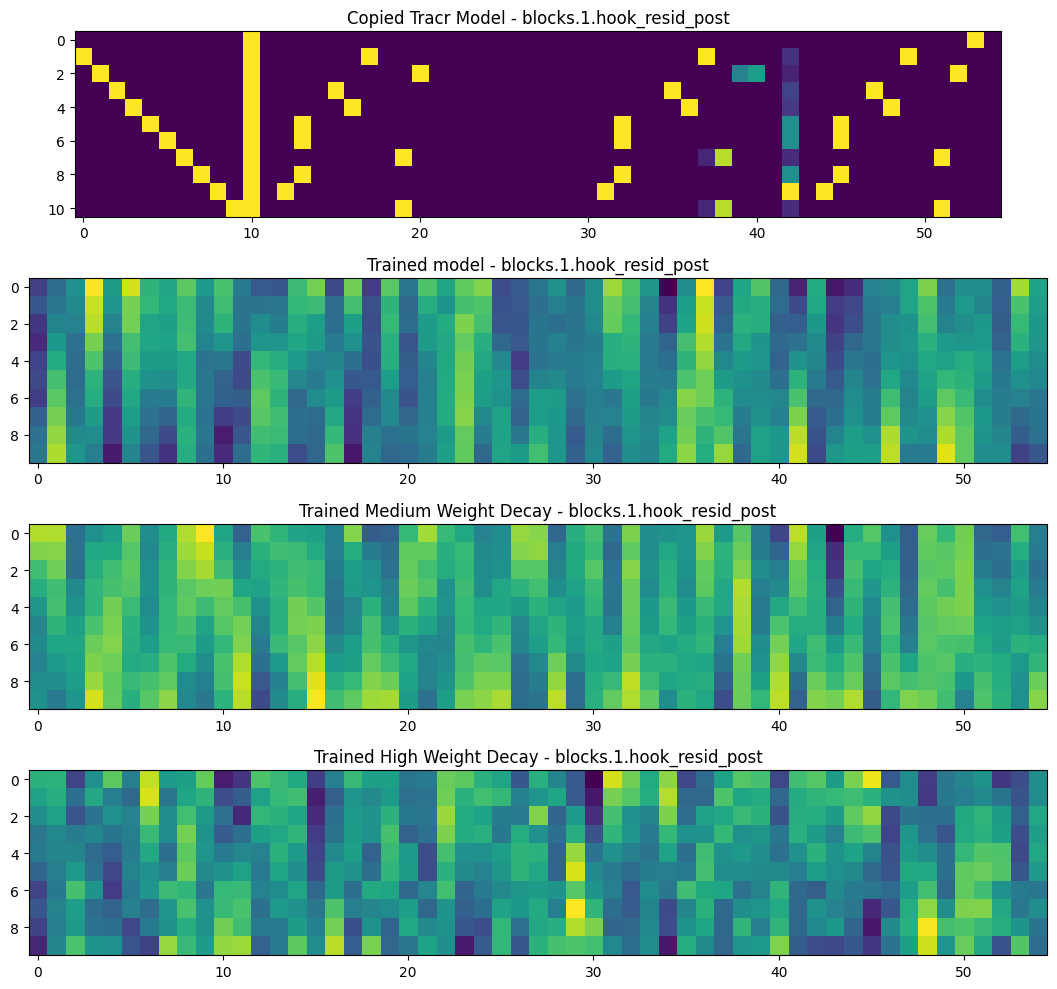

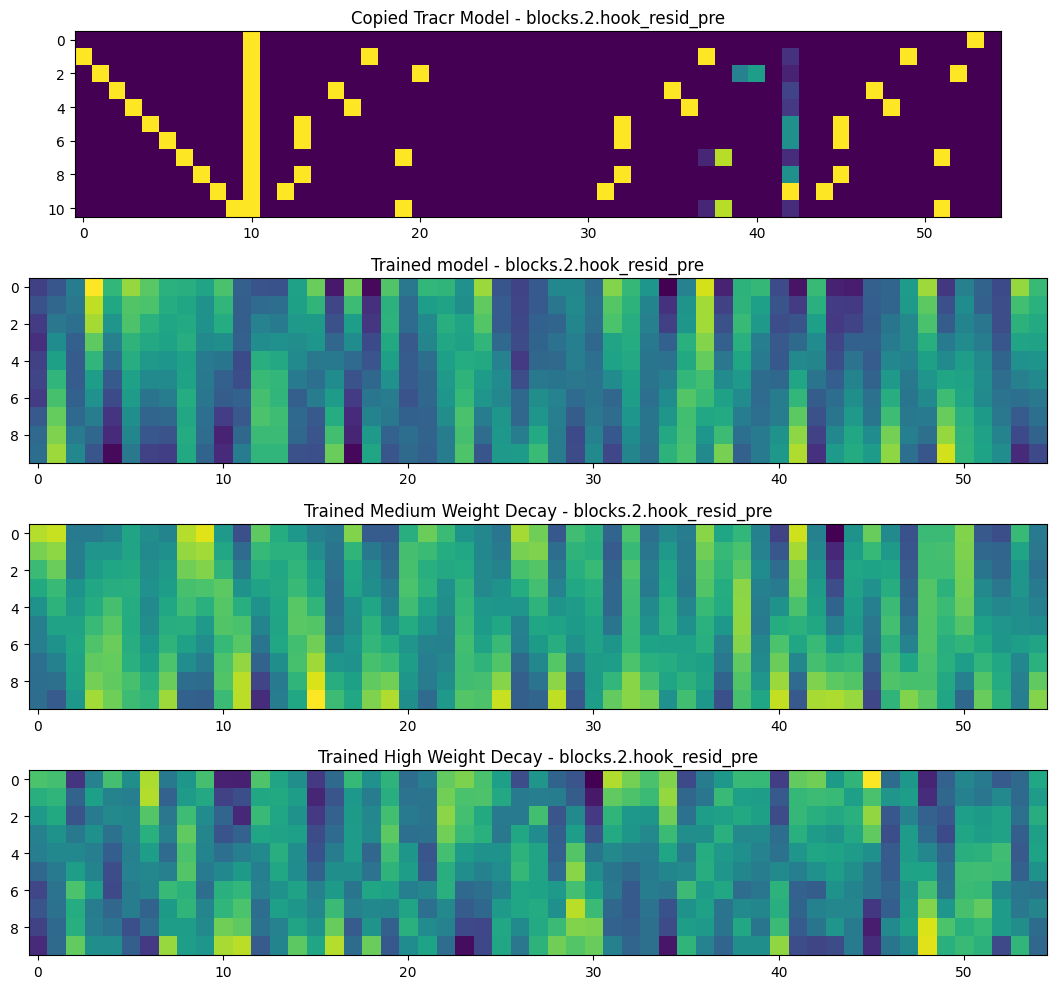

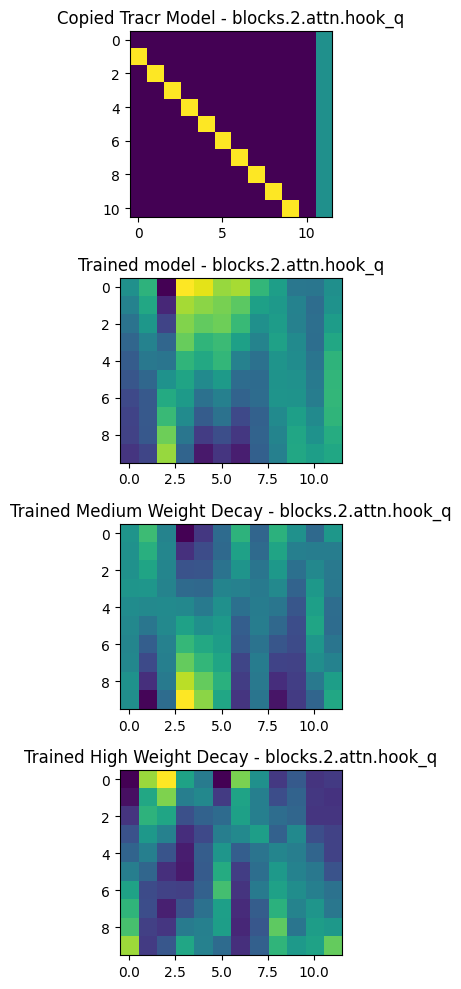

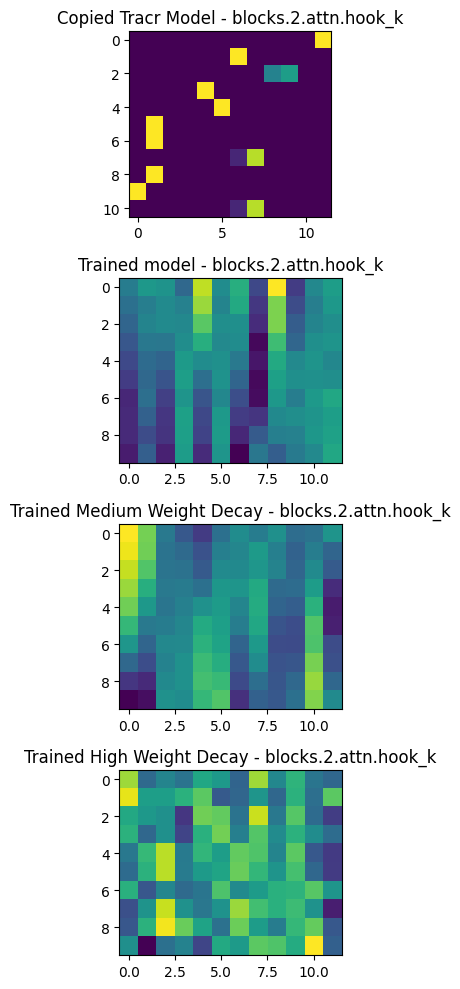

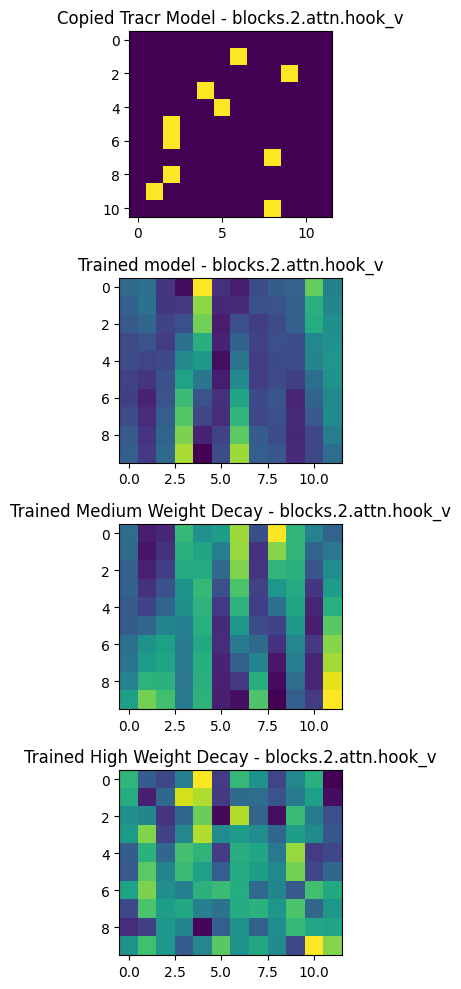

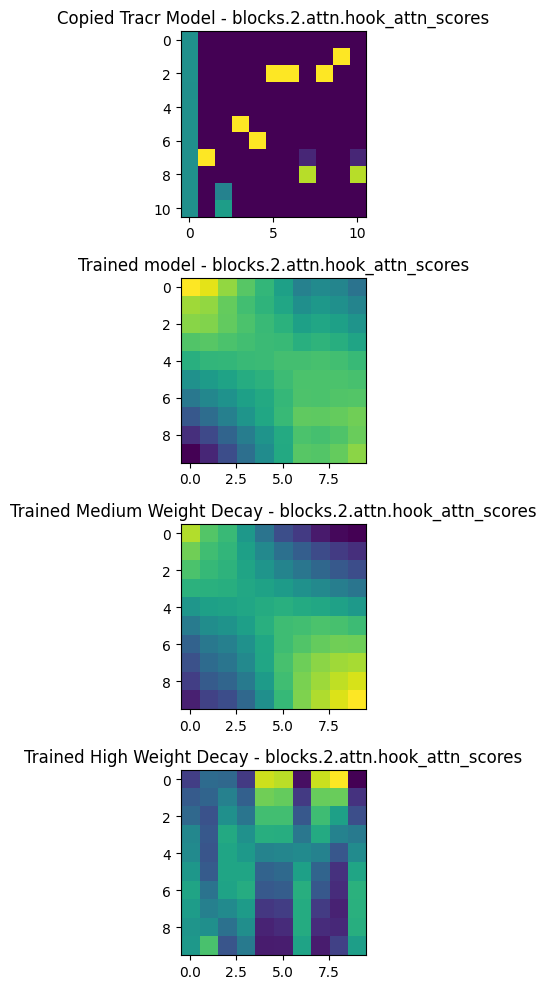

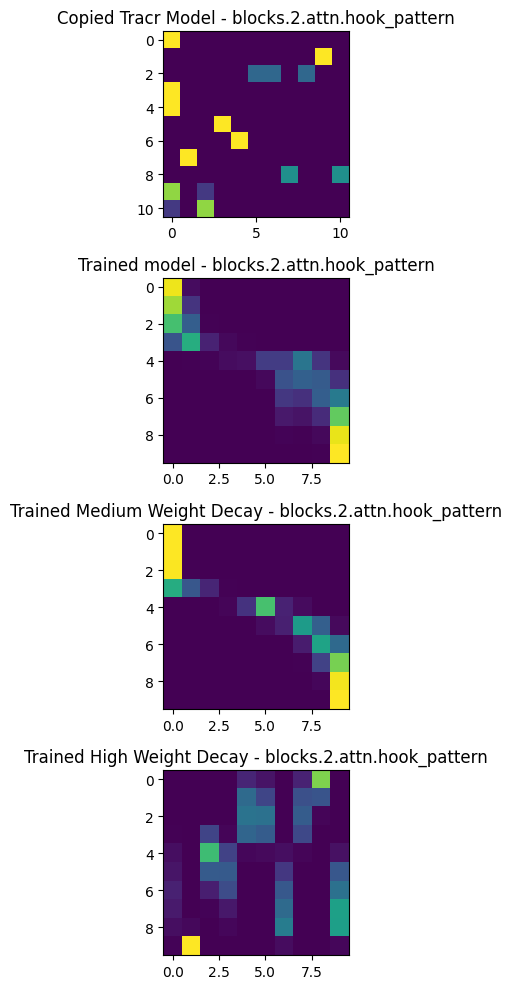

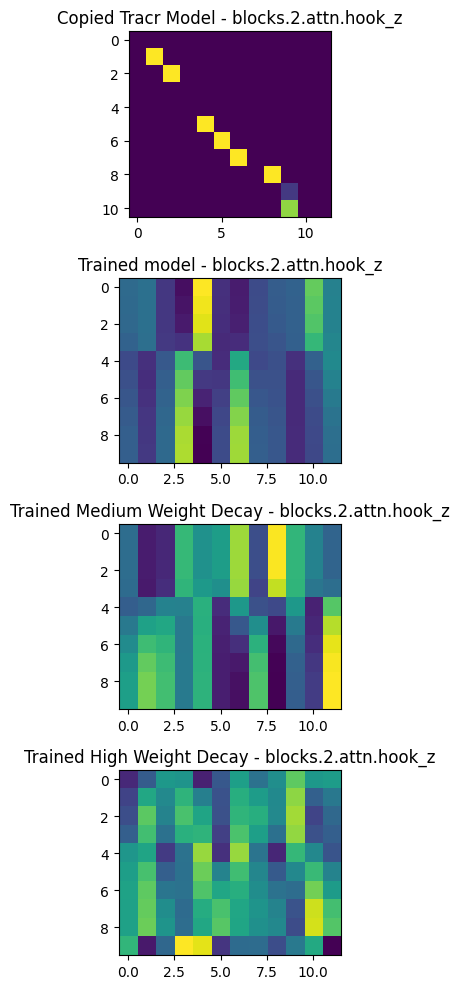

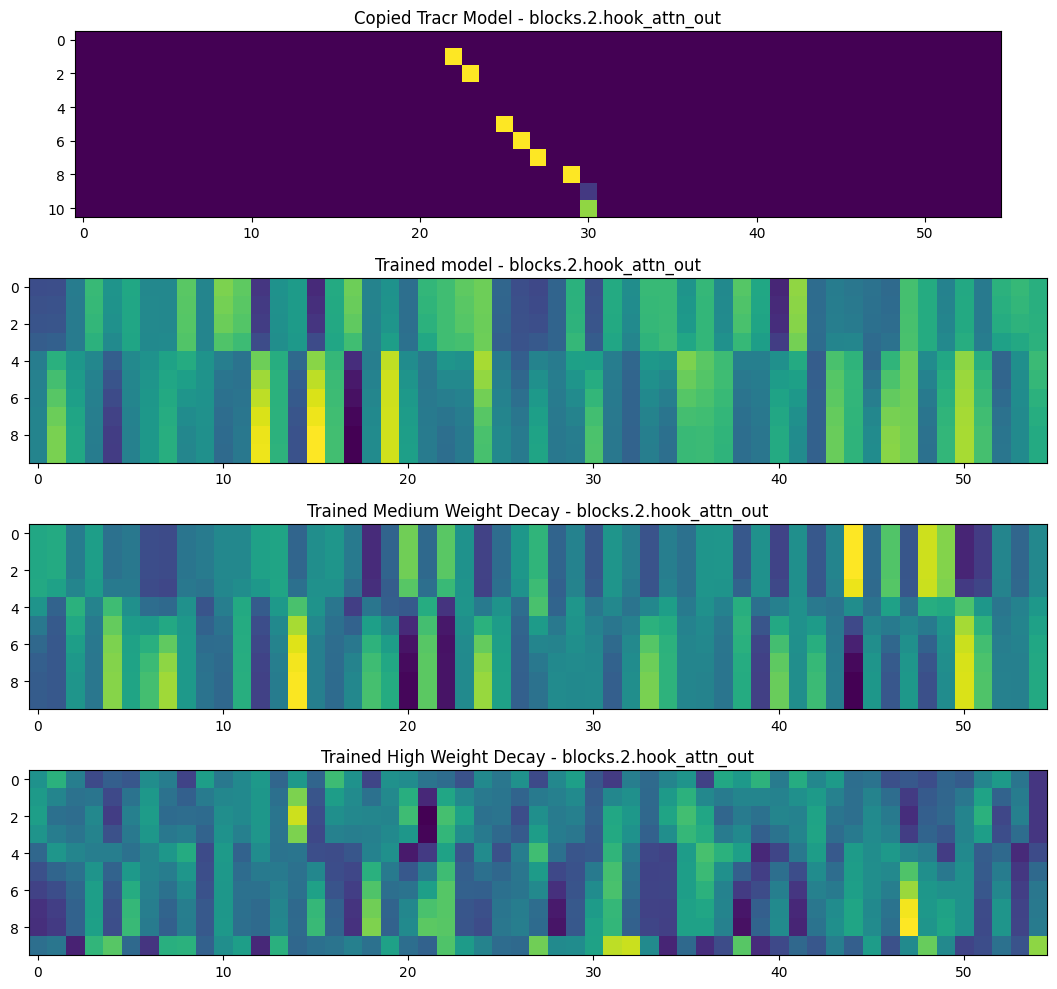

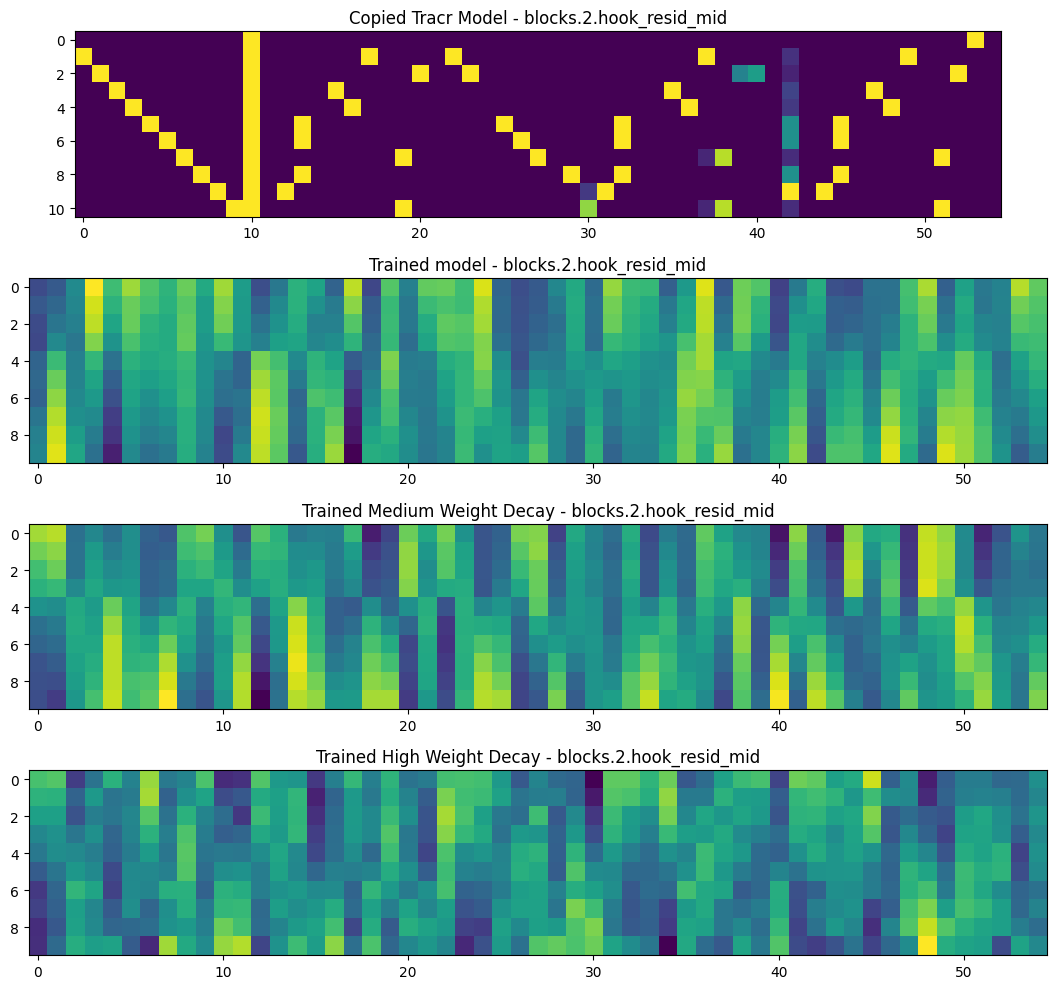

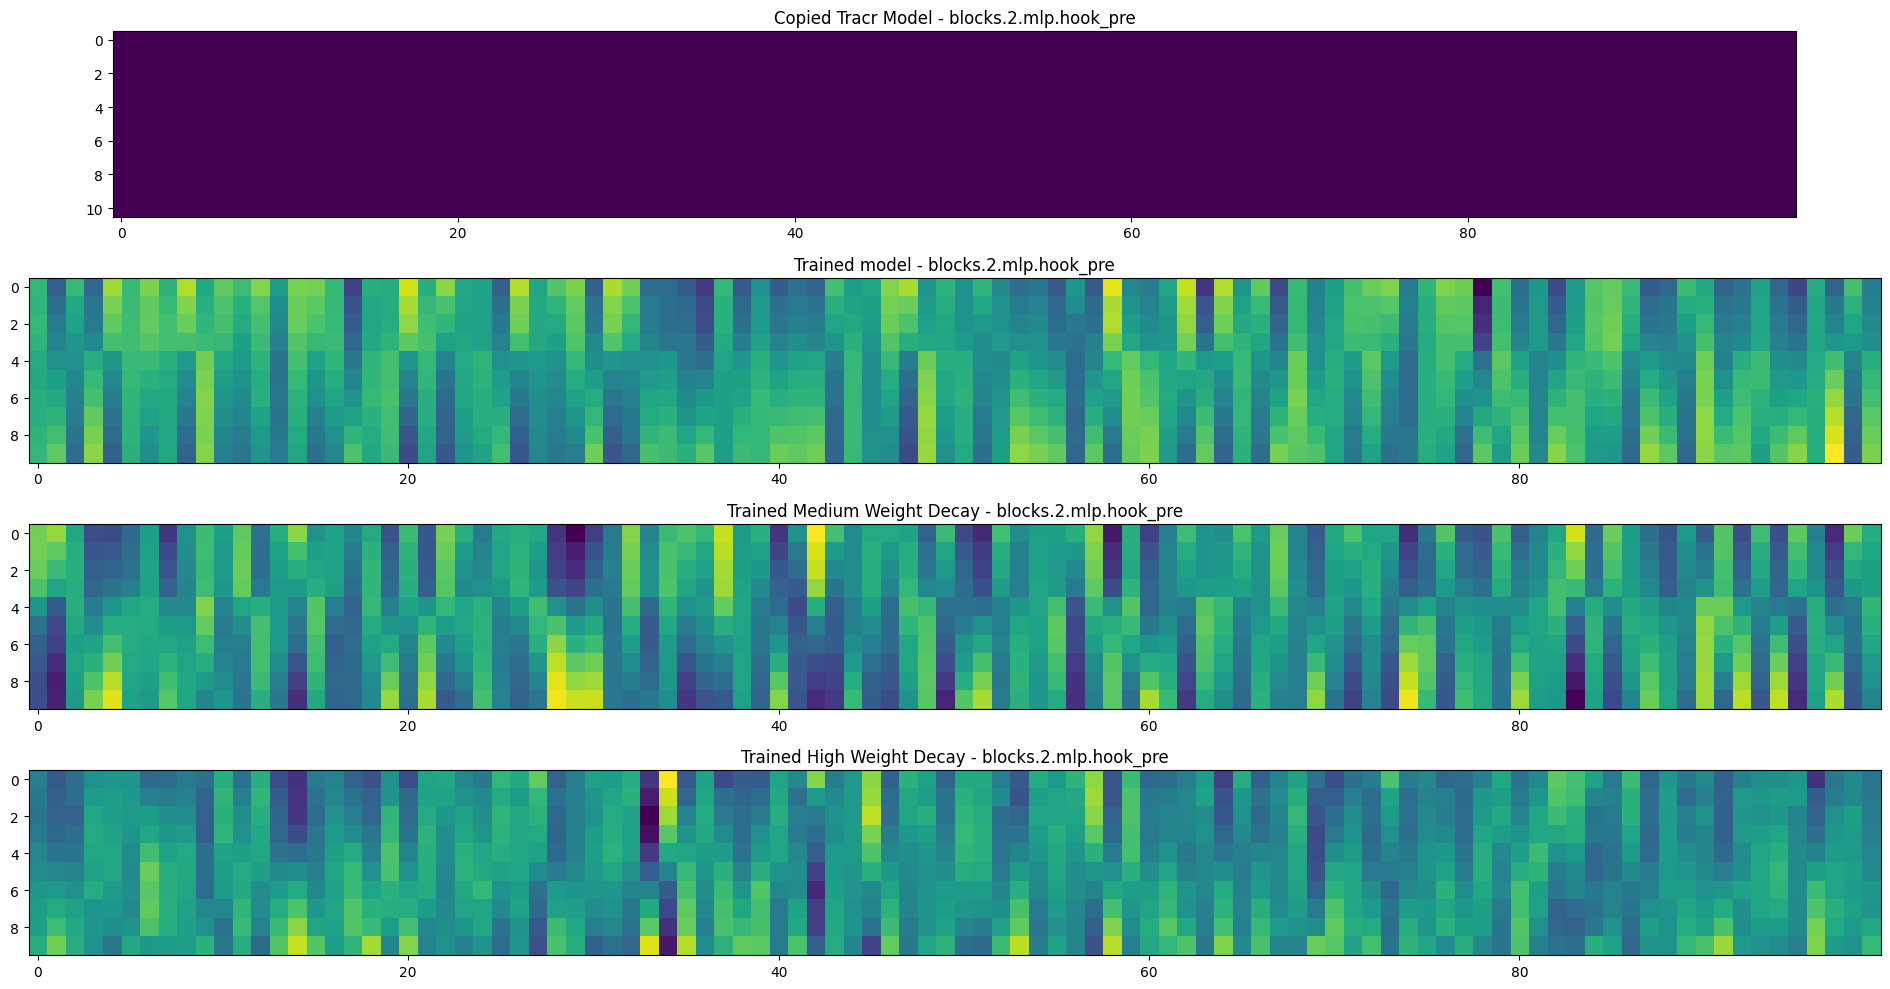

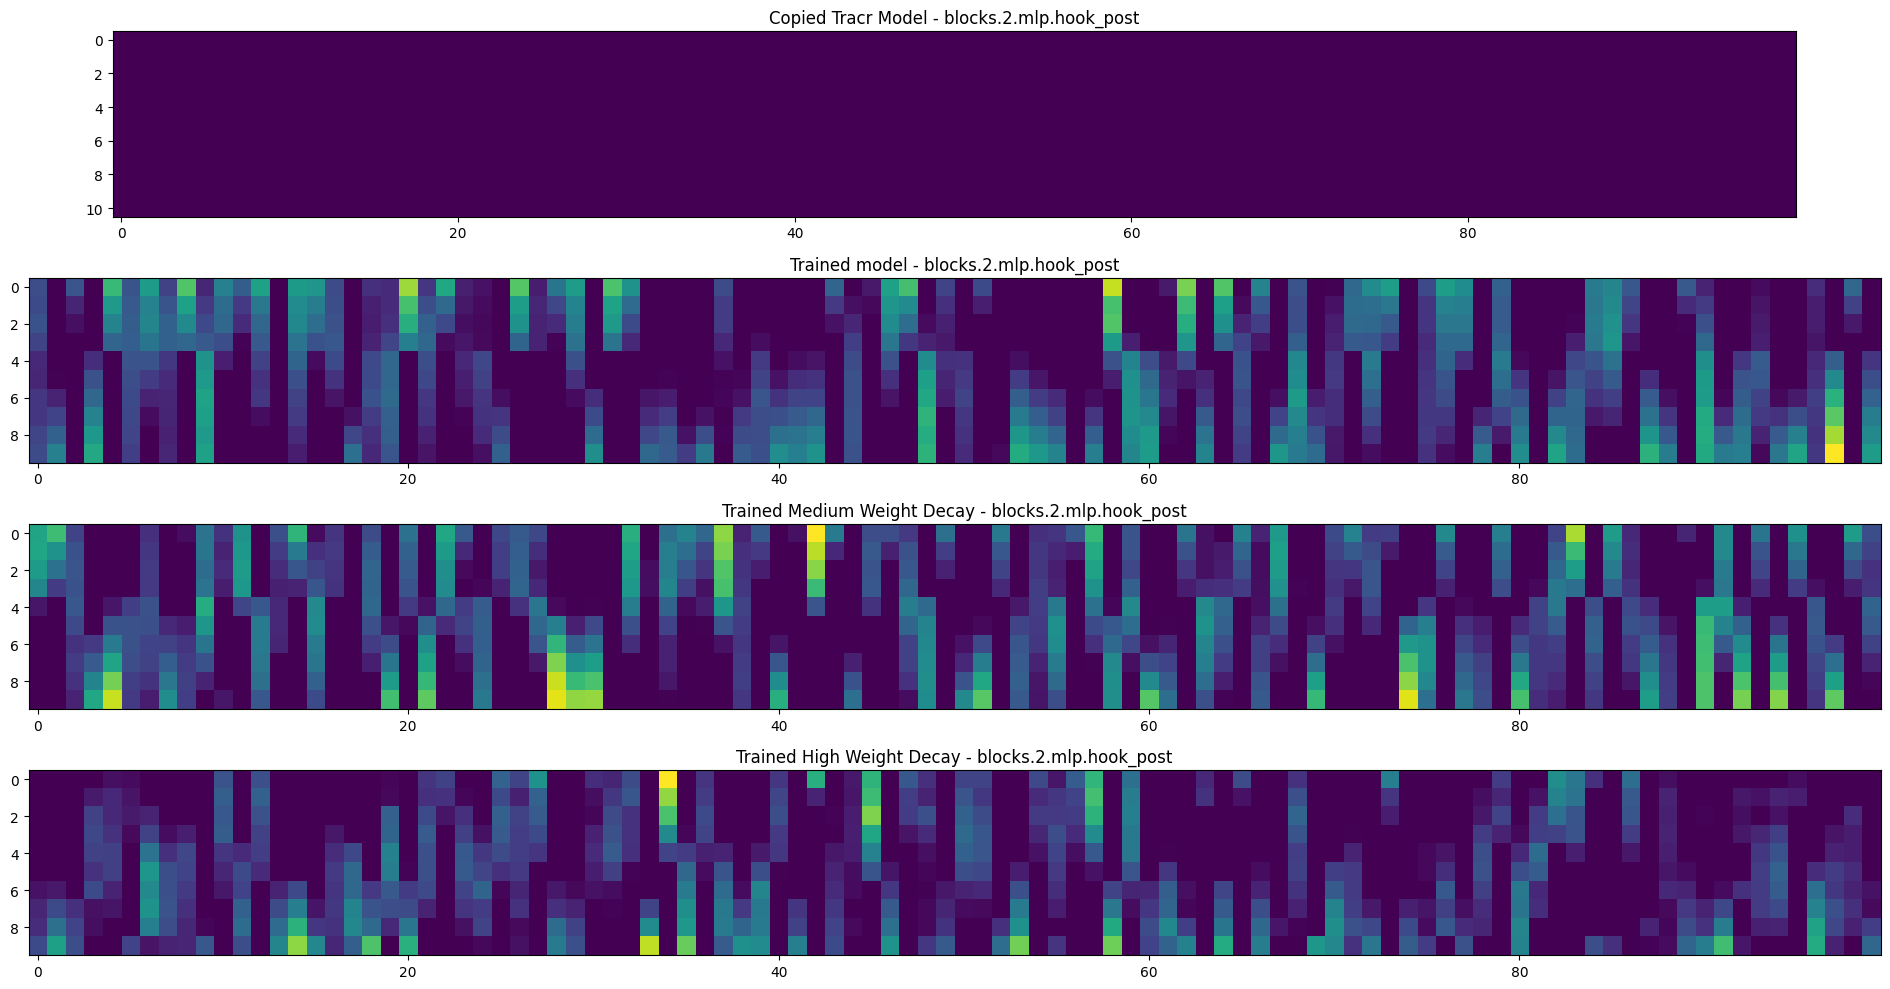

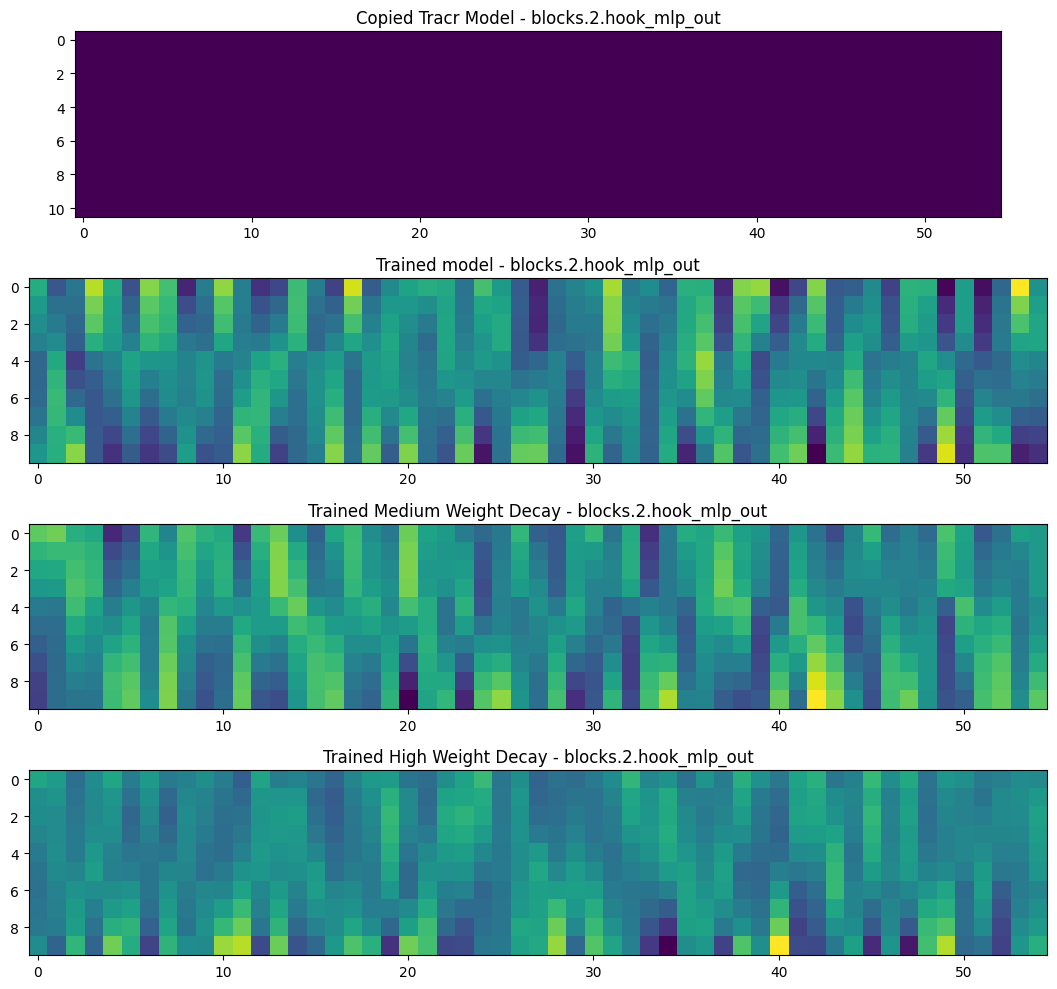

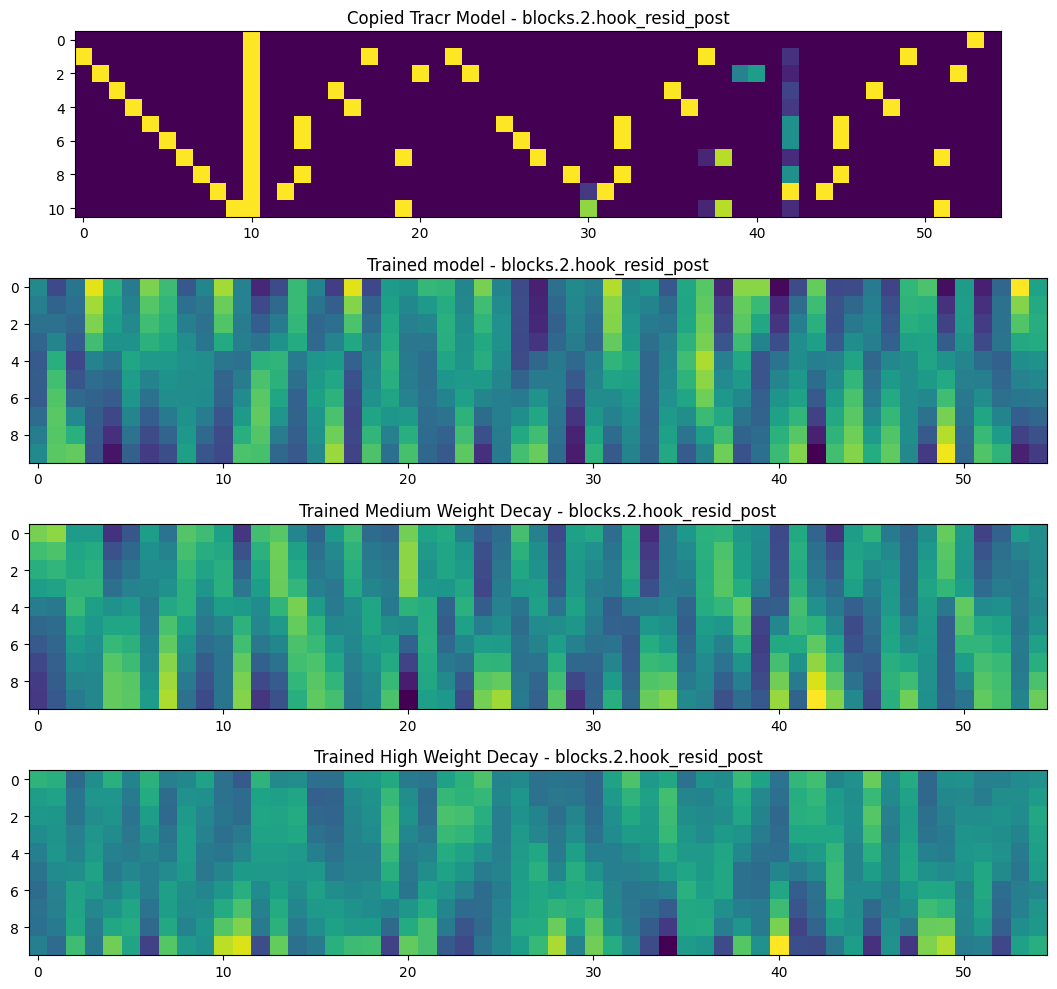

In [132]:
reload_fuctions()
act_caches = [cache.items() for cache in [tracr_cache, trained_cache, trained_mid_decay_cache, trained_high_decay_cache]]
act_zipped = [*zip(*act_caches)][2:]
labels = ["Copied Tracr Model", "Trained model", "Trained Medium Weight Decay", "Trained High Weight Decay"]

for i, activations in enumerate(act_zipped):
    plot_activations(
        [f"{labels[i]} - {activations[i][0]}" for i in range(len(activations))],
        *[to_numpy(activation[1]) for activation in activations]
    )


In [13]:
_, cache = run_with_activations(tr_model, x)

In [25]:
prompt(assembled_model, x)

[0, 1, 4, 2, 4, 4, 5, 5, 6, 9]

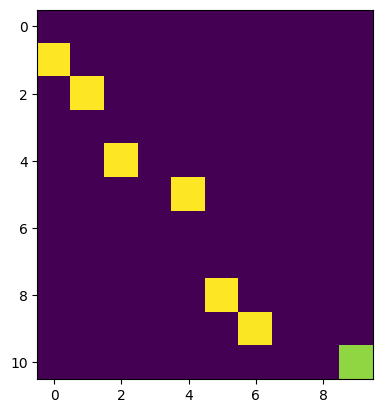

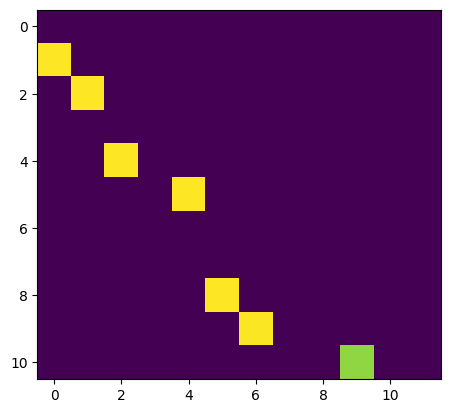

array([ 1,  2,  4,  0,  5,  8,  9,  0,  0, 10])

In [30]:
mat = tracr_cache['blocks.2.attn.hook_z'].cpu().numpy()
matz = tracr_cache['blocks.2.attn.hook_z'].squeeze().cpu().numpy()
plt.imshow(mat)
plt.show()
plt.imshow(matz)
plt.show()

In [31]:
decode_model_output(mat, OUTPUT_ENCODER)

[0, 1, 4, 2, 4, 4, 5, 5, 6, 9]